# Developer Data Analysis

**Author:** Allison Ceballos Alvarez\
**Date:** November, 2025

---

## 1. Introduction

**Goal:** This project analyzes the **2024 Stack Overflow Developer Survey** to uncover major trends in the software development industry.

**Dataset:** I use the official 2024 public dataframe from Stack Overflow, containing responses from tens of thousands of developers worldwide. This dataframe provides insights into developer roles, technologies, salaries, education, and job satisfaction.

The dataframe is available as part of the Stack Overflow Developer Survey under an Open Database License (ODbL), which permits use, modification, and sharing. Access the complete survey results, raw data, and methodology at this [link](https://survey.stackoverflow.co/).

**Research Questions:**

1. The 2024 Developer Profile
* Who is the typical developer in terms of demographics, experience, and education?

2. The Developer's Toolkit
* What are the most used and most desired technologies?

3. Compensation & Career
* What factors correlate most strongly with salary?
* How does compensation vary by experience level and role?
* Which technologies are associated with the highest paying positions?

---

## 2. Data Preparation & Cleaning

### 2.1 Load & Inspect Data

Import the libraries.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

from plotly.subplots import make_subplots

**Data Loading Strategy:** 

To ensure this notebook runs seamlessly in cloud environments (Google Colab) without requiring manual file uploads, the data is loaded directly from the GitHub repository. Since the raw dataset exceeds GitHub's file size limit, the code retrieves a compressed ZIP file from the URL and reads it immediately using Pandas, ensuring full reproducibility.

In [2]:
# URL pointing to the raw ZIP file hosted on the GitHub repository
url_zip = 'https://github.com/itsalialvarz/Developer-Data-Analysis/raw/main/survey_results_public.zip'
try:
    # Attempt to load data directly from the GitHub URL with automatic ZIP decompression
    df = pd.read_csv(url_zip, compression='zip')
    print("Data loaded successfully from GitHub (ZIP).")
except Exception as e:
    # Fallback: If the remote load fails, attempt to load from a local CSV file
    print("Could not load from GitHub. Attempting to load local file...")
    
    try:
        # Load the CSV file from the local directory
        df = pd.read_csv('survey_results_public.csv')
        print("Data loaded from local CSV file.")
    except FileNotFoundError:
        print("Error: Dataset not found (neither online or locally).")

Could not load from GitHub. Attempting to load local file...
Data loaded from local CSV file.


Below are the first five rows of the dataframe, providing an initial view of the data structure and available variables.

In [3]:
pd.set_option('display.max_columns', None) # Set pandas option to display all columns
df.head() # Display the first few rows of the dataframe

ResponseId                      MainBranch                 Age  \
0           1  I am a developer by profession  Under 18 years old   
1           2  I am a developer by profession     35-44 years old   
2           3  I am a developer by profession     45-54 years old   
3           4           I am learning to code     18-24 years old   
4           5  I am a developer by profession     18-24 years old   

            Employment RemoteWork   Check  \
0  Employed, full-time     Remote  Apples   
1  Employed, full-time     Remote  Apples   
2  Employed, full-time     Remote  Apples   
3   Student, full-time        NaN  Apples   
4   Student, full-time        NaN  Apples   

                                    CodingActivities  \
0                                              Hobby   
1  Hobby;Contribute to open-source projects;Other...   
2  Hobby;Contribute to open-source projects;Other...   
3                                                NaN   
4                                                NaN   

                                             EdLevel  \
0                          Primary/elementary school   
1       Bachelor’s degree (B.A., B.S., B.Eng., etc.)   
2    Master’s degree (M.A., M.S., M.Eng., MBA, etc.)   
3  Some college/university study without earning ...   
4  Secondary school (e.g. American high school, G...   

                                           LearnCode  \
0                             Books / Physical media   
1  Books / Physical media;Colleague;On the job tr...   
2  Books / Physical media;Colleague;On the job tr...   
3  Other online resources (e.g., videos, blogs, f...   
4  Other online resources (e.g., videos, blogs, f...   

                                     LearnCodeOnline  \
0                                                NaN   
1  Technical documentation;Blogs;Books;Written Tu...   
2  Technical documentation;Blogs;Books;Written Tu...   
3  Stack Overflow;How-to videos;Interactive tutorial   
4  Technical documentation;Blogs;Written Tutorial...   

                                             TechDoc YearsCode YearsCodePro  \
0                                                NaN       NaN          NaN   
1  API document(s) and/or SDK document(s);User gu...        20           17   
2  API document(s) and/or SDK document(s);User gu...        37           27   
3                                                NaN         4          NaN   
4  API document(s) and/or SDK document(s);User gu...         9          NaN   

                 DevType OrgSize PurchaseInfluence BuyNewTool BuildvsBuy  \
0                    NaN     NaN               NaN        NaN        NaN   
1  Developer, full-stack     NaN               NaN        NaN        NaN   
2   Developer Experience     NaN               NaN        NaN        NaN   
3  Developer, full-stack     NaN               NaN        NaN        NaN   
4  Developer, full-stack     NaN               NaN        NaN        NaN   

  TechEndorse                                            Country Currency  \
0         NaN                           United States of America      NaN   
1         NaN  United Kingdom of Great Britain and Northern I...      NaN   
2         NaN  United Kingdom of Great Britain and Northern I...      NaN   
3         NaN                                             Canada      NaN   
4         NaN                                             Norway      NaN   

   CompTotal                             LanguageHaveWorkedWith  \
0        NaN                                                NaN   
1        NaN  Bash/Shell (all shells);Go;HTML/CSS;Java;JavaS...   
2        NaN                                                 C#   
3        NaN  C;C++;HTML/CSS;Java;JavaScript;PHP;PowerShell;...   
4        NaN            C++;HTML/CSS;JavaScript;Lua;Python;Rust   

                              LanguageWantToWorkWith  \
0                                                NaN   
1  Bash/Shell (all shells);Go;HTML/CSS;Java;JavaS...   
2  

I first examined the dataframe size to understand the scope of the analysis. The survey captured [65457, 114] responses from developers worldwide.

In [4]:
print(df.shape) # Print the dataframe dimensions

(65457, 114)


The following table shows the data type for each variable in the dataframe:

In [5]:
print(df.dtypes) # Print the data type for each column

ResponseId               int64
MainBranch              object
Age                     object
Employment              object
RemoteWork              object
                        ...   
JobSatPoints_11        float64
SurveyLength            object
SurveyEase              object
ConvertedCompYearly    float64
JobSat                 float64
Length: 114, dtype: object


### 2.2 Handling Duplicates

To ensure data integrity, I examined the dataframe for duplicate entries. This step is critical for maintaining accurate frequency counts and preventing bias in subsequent statistical analyses.

In [6]:
print("\n--- Duplicate Analysis ---")
print(f"Original number of rows: {len(df)}")
duplicate_count = df.duplicated().sum() # Count the number of duplicate rows in the dataframe
print(f"Number of duplicate rows found: {duplicate_count}")

duplicate_mask = df.duplicated(keep=False) # Create a boolean mask identifying all duplicate rows
duplicate_rows = df[duplicate_mask] # Filter the dataframe to extract only duplicate rows
duplicate_rows_sorted = duplicate_rows.sort_values(by=list(df.columns)) # Sort the duplicate rows

print("Displaying first 10 duplicate rows (grouped together):")
duplicate_rows_sorted.head(10)


--- Duplicate Analysis ---
Original number of rows: 65457
Number of duplicate rows found: 20
Displaying first 10 duplicate rows (grouped together):


ResponseId                      MainBranch                 Age  \
0               1  I am a developer by profession  Under 18 years old   
65437           1  I am a developer by profession  Under 18 years old   
1               2  I am a developer by profession     35-44 years old   
65438           2  I am a developer by profession     35-44 years old   
2               3  I am a developer by profession     45-54 years old   
65439           3  I am a developer by profession     45-54 years old   
3               4           I am learning to code     18-24 years old   
65440           4           I am learning to code     18-24 years old   
4               5  I am a developer by profession     18-24 years old   
65441           5  I am a developer by profession     18-24 years old   

                Employment RemoteWork   Check  \
0      Employed, full-time     Remote  Apples   
65437  Employed, full-time     Remote  Apples   
1      Employed, full-time     Remote  Apples   
65438  Employed, full-time     Remote  Apples   
2      Employed, full-time     Remote  Apples   
65439  Employed, full-time     Remote  Apples   
3       Student, full-time        NaN  Apples   
65440   Student, full-time        NaN  Apples   
4       Student, full-time        NaN  Apples   
65441   Student, full-time        NaN  Apples   

                                        CodingActivities  \
0                                                  Hobby   
65437                                              Hobby   
1      Hobby;Contribute to open-source projects;Other...   
65438  Hobby;Contribute to open-source projects;Other...   
2      Hobby;Contribute to open-source projects;Other...   
65439  Hobby;Contribute to open-source projects;Other...   
3                                                    NaN   
65440                                                NaN   
4                                                    NaN   
65441                                                NaN   

                                                 EdLevel  \
0                              Primary/elementary school   
65437                          Primary/elementary school   
1           Bachelor’s degree (B.A., B.S., B.Eng., etc.)   
65438       Bachelor’s degree (B.A., B.S., B.Eng., etc.)   
2        Master’s degree (M.A., M.S., M.Eng., MBA, etc.)   
65439    Master’s degree (M.A., M.S., M.Eng., MBA, etc.)   
3      Some college/university study without earning ...   
65440  Some college/university study without earning ...   
4      Secondary school (e.g. American high school, G...   
65441  Secondary school (e.g. American high school, G...   

                                               LearnCode  \
0                                 Books / Physical media   
65437                             Books / Physical media   
1      Books / Physical media;Colleague;On the job tr...   
65438  Books / Physical media;Colleague;On the job tr...   
2      Books / Physical media;Colleague;On the job tr...   
65439  Books / Physical media;Colleague;On the job tr...   
3      Other online resources (e.g., videos, blogs, f...   
65440  Other online resources (e.g., videos, blogs, f...   
4      Other online resources (e.g., videos, blogs, f...   
65441  Other online resources (e.g., videos, blogs, f...   

                                         LearnCodeOnline  \
0                                                    NaN   
65437                                                NaN   
1      Technical documentation;Blogs;Books;Written Tu...   
65438  Technical documentation;Blogs;Books;Written Tu...   
2      Technical documentation;Blogs;Books;Written Tu...   
65439  Technical documentation;Blogs;Books;Written Tu...   
3      Stack Overflow;How-to videos;Interactive tutorial   
65440  Stack Overflow;How-to videos;Interactive tutorial   
4      Technical documentation;Blogs;Written Tutorial...   
65441  Technical documentation;Blogs;Written Tutorial...   

                   

#### Duplicate Handling

The `ResponseId` column uniquely identifies each survey respondent, making it the appropriate field for detecting duplicates. I applied drop_duplicates(subset=['ResponseId'], keep='first') to remove 20 duplicate submissions, retaining only the first response from each individual. 

This "one respondent, one row" structure is essential for accurate frequency analysis and prevents double counting in all subsequent calculations.

In [7]:
critical_column = ['ResponseId'] # Define the column used to identify duplicate records
print(f"Original shape of data: {df.shape}") # Record the initial dataframe dimensions

# Remove duplicate records based on ResponseId, retaining the first occurrence
df_clean = df.drop_duplicates(subset=critical_column, keep='first').copy()

print(f"Shape after dropping duplicates: {df_clean.shape}") # Record the dataframe dimensions after deduplication
print(f"Total rows removed: {df.shape[0] - df_clean.shape[0]}") # Calculate and display the number of duplicate rows removed

Original shape of data: (65457, 114)
Shape after dropping duplicates: (65437, 114)
Total rows removed: 20


### 2.3 Managing Missing Data

I assessed missing values across all columns to determine data quality and guide my cleaning strategy. The table below shows the count of missing values for each variable.

In [8]:
missing_series = df_clean.isnull().sum() # Calculate missing values
missing_filtered = missing_series[missing_series > 0].reset_index() # Filter the Series to only include columns where the count is > 0
missing_filtered.columns = ['Column', 'Missing Values'] # Rename columns
missing_filtered = missing_filtered.sort_values(by='Missing Values', ascending=False) # Sort the filtered series

print("Missing values count per column (sorted):")
print(missing_filtered) # Display columns with missing values

Missing values count per column (sorted):
                        Column  Missing Values
70  AINextMuch less integrated           64289
69       AINextLess integrated           63082
67             AINextNo change           52939
66  AINextMuch more integrated           51999
31             EmbeddedAdmired           48704
..                         ...             ...
6                    YearsCode            5568
52                  NEWSOSites            5151
3                    LearnCode            4949
2                      EdLevel            4653
58                    AISelect            4530

[109 rows x 2 columns]


To prioritize data cleaning decisions, I created a visualization showing missing data proportions across all columns.

In [9]:
# Sort by missing value count in ascending order
missing_filtered = missing_filtered.sort_values(by='Missing Values')

# Create the visualization
fig = px.bar(missing_filtered, 
             x='Column', 
             y='Missing Values',
             title='Missing Values per Column (Only Columns with Missing Data)',
             color='Missing Values',
             color_continuous_scale='plasma',
             width=1100,
             height=800)

# Format x-axis and add caption
fig.update_xaxes(tickangle=90,
                 title_text='Survey Column<br><br><sub>Figure 1. Missing Values per Column (Only Columns with Missing Data)</sub>') # Add caption below x-axis title
fig.show() # Show plot

I categorized the dataframe's columns into seven thematic groups to analyze missing data patterns:

1. Basic Information
2. Education, Work & Career
3. Technology & Culture
4. Stack Overflow Usage
5. Artificial Intelligence
6. Professional Developer Series
7. Metadata

In [10]:
def categorize_column(col_name):
    # Assigns a category to a column name based on the official 2024 Stack Overflow Survey sections
    # Section 1: Basic Information
    cat_1_basic = ['ResponseId', 'Check', 'MainBranch', 'Age', 'Age_Numeric',
                   'Employment', 'RemoteWork', 'CodingActivities']
    if col_name in cat_1_basic:
        return '1. Basic Information'

    # Section 2: Education, Work, and Career
    cat_2_career = ['EdLevel', 'LearnCode', 'LearnCodeOnline', 'TechDoc',
                    'YearsCode', 'YearsCodePro', 'DevType', 'OrgSize',
                    'PurchaseInfluence', 'BuyNewTool', 'BuildvsBuy',
                    'TechEndorse', 'Country', 'CompTotal', 'Currency',
                    'ConvertedCompYearly']
    if col_name in cat_2_career:
        return '2. Education, Work & Career'

    # Section 3: Technology and Culture
    cat_3_tech_prefixes = ('Language', 'Database', 'Platform', 'Webframe',
                           'Embedded', 'MiscTech', 'ToolsTech', 'NEWCollabTools',
                           'OpSys', 'OfficeStack', 'AISearchDev')
    if col_name.startswith(cat_3_tech_prefixes):
        return '3. Technology & Culture'

    # Section 4: Stack Overflow Usage + Community
    cat_4_so = ['NEWSOSites', 'SOVisitFreq', 'SOAccount',
                'SOPartFreq', 'SOHow', 'SOComm']
    if col_name in cat_4_so:
        return '4. Stack Overflow Usage'

    # Section 5: Artificial Intelligence
    # This catches all 'AI' columns after 'AISearchDev' was
    # already assigned to Section 3
    if col_name.startswith('AI'):
        return '5. Artificial Intelligence'

    # Section 6: Professional Developer Series
    cat_6_prof_prefixes = ('Knowledge_', 'Frequency_', 'JobSatPoints_')
    cat_6_prof_main = ['TBranch', 'ICorPM', 'WorkExp', 'TimeSearching',
                       'TimeAnswering', 'Frustration', 'ProfessionalTech',
                       'ProfessionalCloud', 'ProfessionalQuestion',
                       'Industry', 'JobSat', 'SOTeamsUsage']
    if col_name.startswith(cat_6_prof_prefixes) or col_name in cat_6_prof_main:
        return '6. Professional Dev Series'
    
    # Section 7. Metadata
    cat_7_meta = ['SurveyLength', 'SurveyEase']
    if col_name in cat_7_meta:
        return '7. Metadata'

    # Fallback category
    return 'Other'

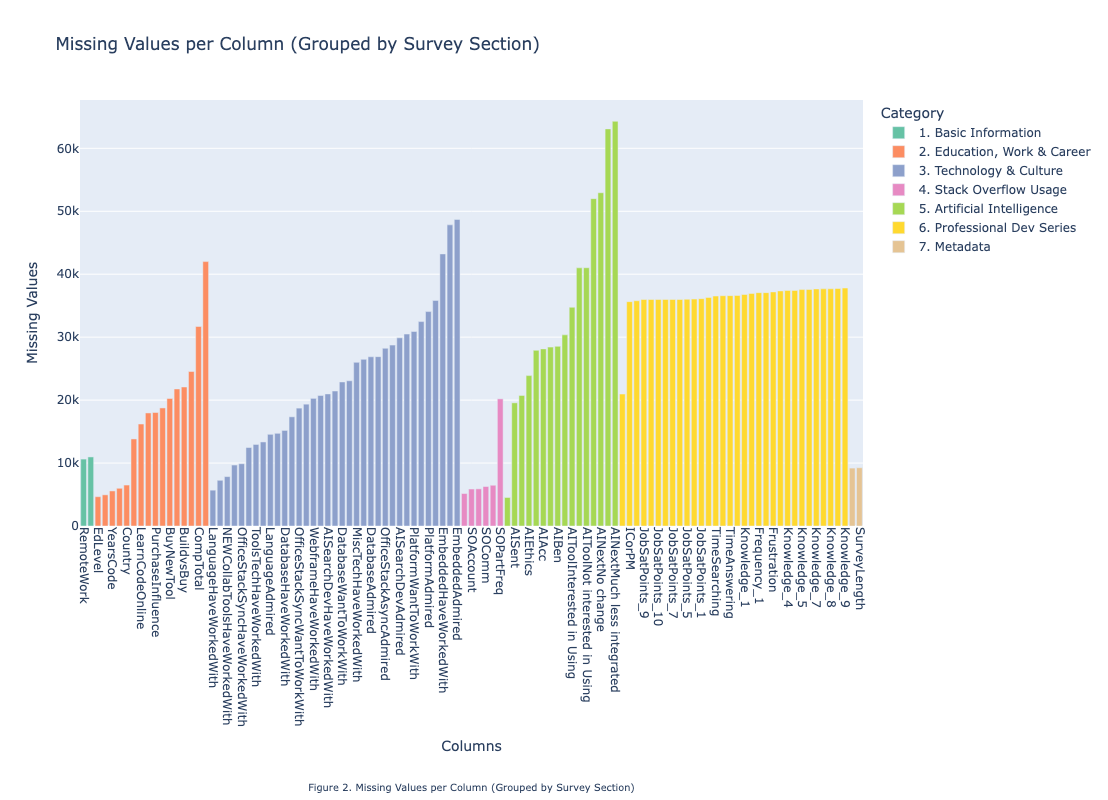

In [11]:
# Apply the new categorization
missing_filtered.columns = ['Columns', 'Missing Values'] # Rename the columns for Plotly
missing_filtered['Category'] = missing_filtered['Columns'].apply(categorize_column) # Apply the categorize_column function
missing_filtered = missing_filtered.sort_values(by=['Category', 'Missing Values']) # Sort by the new categories to group them together

# Create the bar chart
fig = px.bar(missing_filtered,
             x='Columns',
             y='Missing Values',
             title='Missing Values per Column (Grouped by Survey Section)',
             color='Category',
             custom_data=['Category', 'Columns', 'Missing Values'],
             color_discrete_sequence=px.colors.qualitative.Set2)

# Configure layout settings
fig.update_layout(
    width=1100,
    height=800,
    xaxis_title="Survey Column",
    yaxis_title="Missing Values",
    xaxis_categoryorder='array',
    xaxis_categoryarray=missing_filtered['Columns'])

# Use fig.update_traces to define the template of the hover
fig.update_traces(
    hovertemplate =(
    "<b>%{customdata[0]}</b><br>" +
    "<br>%{x}<br>" +
    "Missing Values: %{customdata[2]:,.0f}") +
    "<extra></extra>")

# Format x-axis and add caption
fig.update_xaxes(tickangle=90,
                 title_text='Columns<br><br><sub>Figure 2. Missing Values per Column (Grouped by Survey Section)</sub>') # Add caption below x-axis title
fig.show() # Show plot

#### 2.3.1 Dropping Irrelevant Columns

To streamline the dataframe for analysis, I removed several columns that do not contribute to the project's research questions:

* **`ResponseId`**: Served as a primary key for duplicate detection but has no analytical value.
* **`Check`**: An attention check question (Select 'Apples') used for survey validation only.
* **`CompTotal` & `Currency`**: Raw, non standardized compensation data. All salary analysis uses `ConvertedCompYearly`, which is already standardized to USD.
* **`SurveyLength` & `SurveyEase`**: These columns contain metadata about the survey taking experience itself.
* **`Professional Developer Series`**: This optional section (columns `TBranch` through the end of the survey) had missing values and minimal relevance to my research questions. I excluded these columns while preserving ConvertedCompYearly and JobSat, which appear later but are essential for compensation analysis.

This reduced the dataset from 114 to 71 columns, focusing the analysis on variables directly relevant to developer profiles, technology preferences, and compensation trends.

In [12]:
# Define the column we want to keep
cols_to_keep = ['ConvertedCompYearly', 'JobSat']
# Define columns to drop
cols_to_drop = [
    'Check','ResponseId','SurveyLength','SurveyEase',
    'CompTotal','Currency',
    'NEWSOSites','SOVisitFreq','SOAccount',
    'SOPartFreq','SOHow','SOComm']

# Drop everything from 'TBranch' to the end, except what's in 'cols_to_keep'
if 'TBranch' in df_clean.columns:
    tbranch_cols = df_clean.columns[df_clean.columns.get_loc('TBranch'):] # Get all columns from 'TBranch' to the end
    cols_to_drop += [c for c in tbranch_cols if c not in cols_to_keep] # Add all these columns to cols_to_drop except those we want to keep

df_clean.drop(columns=cols_to_drop, errors='ignore', inplace=True) # Drop the columns listed in cols_to_drop from the DataFrame

print(f"New number of columns: {df_clean.shape[1]}")
print(f"Dropped {len(cols_to_drop)} columns.")

# Validate that key columns remain
print("ConvertedCompYearly exists:", 'ConvertedCompYearly' in df_clean.columns)
print("JobSat exists:", 'JobSat' in df_clean.columns)

New number of columns: 71
Dropped 45 columns.
ConvertedCompYearly exists: True
JobSat exists: True


With the column structure refined, I shifted to row level cleaning to address incomplete responses and ensure data quality for analysis.

In [13]:
df_clean.head() # Display the first rows of the targeted dataframe

MainBranch                 Age           Employment  \
0  I am a developer by profession  Under 18 years old  Employed, full-time   
1  I am a developer by profession     35-44 years old  Employed, full-time   
2  I am a developer by profession     45-54 years old  Employed, full-time   
3           I am learning to code     18-24 years old   Student, full-time   
4  I am a developer by profession     18-24 years old   Student, full-time   

  RemoteWork                                   CodingActivities  \
0     Remote                                              Hobby   
1     Remote  Hobby;Contribute to open-source projects;Other...   
2     Remote  Hobby;Contribute to open-source projects;Other...   
3        NaN                                                NaN   
4        NaN                                                NaN   

                                             EdLevel  \
0                          Primary/elementary school   
1       Bachelor’s degree (B.A., B.S., B.Eng., etc.)   
2    Master’s degree (M.A., M.S., M.Eng., MBA, etc.)   
3  Some college/university study without earning ...   
4  Secondary school (e.g. American high school, G...   

                                           LearnCode  \
0                             Books / Physical media   
1  Books / Physical media;Colleague;On the job tr...   
2  Books / Physical media;Colleague;On the job tr...   
3  Other online resources (e.g., videos, blogs, f...   
4  Other online resources (e.g., videos, blogs, f...   

                                     LearnCodeOnline  \
0                                                NaN   
1  Technical documentation;Blogs;Books;Written Tu...   
2  Technical documentation;Blogs;Books;Written Tu...   
3  Stack Overflow;How-to videos;Interactive tutorial   
4  Technical documentation;Blogs;Written Tutorial...   

                                             TechDoc YearsCode YearsCodePro  \
0                                                NaN       NaN          NaN   
1  API document(s) and/or SDK document(s);User gu...        20           17   
2  API document(s) and/or SDK document(s);User gu...        37           27   
3                                                NaN         4          NaN   
4  API document(s) and/or SDK document(s);User gu...         9          NaN   

                 DevType OrgSize PurchaseInfluence BuyNewTool BuildvsBuy  \
0                    NaN     NaN               NaN        NaN        NaN   
1  Developer, full-stack     NaN               NaN        NaN        NaN   
2   Developer Experience     NaN               NaN        NaN        NaN   
3  Developer, full-stack     NaN               NaN        NaN        NaN   
4  Developer, full-stack     NaN               NaN        NaN        NaN   

  TechEndorse                                            Country  \
0         NaN                           United States of America   
1         NaN  United Kingdom of Great Britain and Northern I...   
2         NaN  United Kingdom of Great Britain and Northern I...   
3         NaN                                             Canada   
4         NaN                                             Norway   

                              LanguageHaveWorkedWith  \
0                                                NaN   
1  Bash/Shell (all shells);Go;HTML/CSS;Java;JavaS...   
2                                                 C#   
3  C;C++;HTML/CSS;Java;JavaScript;PHP;PowerShell;...   
4            C++;HTML/CSS;JavaScript;Lua;Python;Rust   

                              LanguageWantToWorkWith  \
0                                                NaN   
1  Bash/Shell (all shells);Go;HTML/CSS;Java;JavaS...   
2                                                 C#   
3  HTML/CSS;Java;JavaScript;PowerShell;Python;SQL...   
4                 C++;HTML/CSS;JavaScript;Lua;Python   

                                     LanguageAdmired  \
0                                                NaN   
1  Bash/Shell

#### 2.3.2 Imputation Strategy

The dataset contains missing values in several key variables. I applied targeted imputation strategies to preserve data while minimizing bias:

* **`EdLevel` (Education):** Imputed missing values with the mode (most common education level). This approach is appropriate for categorical data and maintains the distribution of educational backgrounds without creating artificial categories.

* **`DevType` (Developer Role):** Imputed missing values with "Not Stated" rather than the mode. Since developer roles are diverse and the mode may not represent non respondents, an explicit "Not Stated" category preserves the distinction between respondents who selected a role and those who did not.

This strategy balances data retention with analytical integrity, ensuring that imputation choices don't artificially strengthen patterns that may not exist.

In [14]:
column_to_impute = 'EdLevel' # Target column for imputation
most_frequent_value = df_clean[column_to_impute].mode()[0] # Calculate the mode (most frequent value)

print(f"Column to impute: '{column_to_impute}'")
print(f"Most frequent value: {most_frequent_value}")
print(f"Missing values in '{column_to_impute}' before imputation: {df_clean[column_to_impute].isnull().sum()}")

df_clean.loc[:, column_to_impute] = df_clean[column_to_impute].fillna(most_frequent_value) # Impute the missing values

missing_after = df_clean[column_to_impute].isnull().sum() # Verify the imputation
print(f"Missing values in '{column_to_impute}' after imputation: {missing_after}")

if missing_after == 0:
    print("Imputation successful.")

Column to impute: 'EdLevel'
Most frequent value: Bachelor’s degree (B.A., B.S., B.Eng., etc.)
Missing values in 'EdLevel' before imputation: 4653
Missing values in 'EdLevel' after imputation: 0
Imputation successful.


In [15]:
column_to_impute = 'DevType' # Target column for imputation
impute_value = 'Not Stated'  # Impute 'Not Stated' instead of the mode

print(f"Column to impute: '{column_to_impute}'")
print(f"Imputation value: {impute_value}")
print(f"Missing values in '{column_to_impute}' before imputation: {df_clean[column_to_impute].isnull().sum()}")

df_clean.loc[:, column_to_impute] = df_clean[column_to_impute].fillna(impute_value) # Fill missing values with "Not Stated"

missing_after = df_clean[column_to_impute].isnull().sum()  # Verify the imputation
print(f"Missing values in '{column_to_impute}' after imputation: {missing_after}")

if missing_after == 0:
    print("Imputation successful.")

Column to impute: 'DevType'
Imputation value: Not Stated
Missing values in 'DevType' before imputation: 5992
Missing values in 'DevType' after imputation: 0
Imputation successful.


#### 2.3.3 Identifying and Removing Inconsistencies

Real world survey data often contains the same information in different formats, such as variations in capitalization, spelling, or spacing. I examined key categorical variables for these inconsistencies and standardized them to ensure accurate grouping in subsequent analysis and visualizations.

**Developer Type Data Cleaning**

I standardized developer role labels by removing redundant prefixes, which simplified visualizations and improved readability without losing meaning. For example:

* "Developer, full-stack" to "Full-stack"
* "Senior Executive (C-Suite, VP, etc.)" to "Sr. Executive"
* "Data scientist or machine learning specialist" to "Data Science/ML"

In [16]:
print("--- DevType Column Cleaning Process ---")
print("\nInspecting unique values in the original 'DevType' column:")
print(df_clean['DevType'].unique())

--- DevType Column Cleaning Process ---

Inspecting unique values in the original 'DevType' column:
['Not Stated' 'Developer, full-stack' 'Developer Experience' 'Student'
 'Academic researcher' 'Project manager' 'Developer Advocate'
 'Developer, back-end' 'Other (please specify):' 'Developer, front-end'
 'Database administrator' 'Developer, desktop or enterprise applications'
 'Cloud infrastructure engineer'
 'Data scientist or machine learning specialist'
 'Research & Development role'
 'Developer, embedded applications or devices' 'System administrator'
 'DevOps specialist' 'Engineering manager' 'Designer'
 'Security professional' 'Senior Executive (C-Suite, VP, etc.)'
 'Developer, mobile' 'Developer, game or graphics'
 'Data or business analyst' 'Educator' 'Developer, QA or test'
 'Product manager' 'Developer, AI' 'Scientist'
 'Engineer, site reliability' 'Blockchain'
 'Marketing or sales professional' 'Hardware Engineer' 'Data engineer']


In [17]:
# Define the mapping, descriptive strings to shorter, standardized ones
devlevel_map = {
    'Developer, full-stack': 'Full-stack',
    'Developer, back-end': 'Back-end',
    'Developer, front-end': 'Front-end',
    'Developer, mobile': 'Mobile',
    'Developer, embedded applications or devices': 'Embedded',
    'Developer, game or graphics': 'Game/Graphics',
    'Developer, QA or test': 'QA/Test',
    'Developer, AI': 'AI Dev',
    'Developer, desktop or enterprise applications': 'Desktop/Enterprise',
    'Developer Advocate': 'DA',
    'Developer Experience': 'DX',

    'Data scientist or machine learning specialist': 'Data Science/ML',
    'Data or business analyst': 'Data/Biz Analyst',
    'Data engineer': 'Data Engineer',
    'Database administrator': 'DBA',

    'Cloud infrastructure engineer': 'Cloud Infra',
    'Engineer, site reliability': 'SRE',
    'DevOps specialist': 'DevOps',
    'System administrator': 'SysAdmin',
    'Senior Executive (C-Suite, VP, etc.)': 'Sr. Executive',
    'Engineering manager': 'Eng. MGR',
    'Project manager': 'Project MGR',
    'Product manager': 'Product MGR',
    'Research & Development role': 'R&D',
    'Academic researcher': 'Academic',
    'Security professional': 'Security',
    'Hardware Engineer': 'Hardware Eng.',
    'Marketing or sales professional': 'Marketing/Sales',

    'Not Stated': 'Other',
    'Other (please specify):': 'Other'
}

# Apply the mapping
df_clean['DevType_clean'] = df_clean['DevType'].replace(devlevel_map) # The .replace() function applies the dictionary mapping to the 'DevType' column

# Verify the results
print("Displaying top 10 values counts for the new 'DevType_clean' column:")
print(df_clean['DevType_clean'].value_counts().head(10)) # Using .value_counts() to check the distribution of the new, clean categories

Displaying top 10 values counts for the new 'DevType_clean' column:
DevType_clean
Full-stack            18260
Back-end               9928
Other                  8450
Student                5102
Front-end              3349
Desktop/Enterprise     2493
Mobile                 2021
Embedded               1623
Eng. MGR               1275
Academic               1238
Name: count, dtype: int64


**Education Level Data Cleaning**

I standardized education level descriptions by removing verbose explanations and parentheticals. For example:

**Before:** "Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)"\
**After:** "Secondary school"

The cleaned categories maintain the same hierarchical structure while being more concise for analysis and visualization.

In [18]:
print("--- Education Level [EdLevel] Cleaning Process ---")
# Inspect original values
print("Inspecting unique values in the original 'EdLevel' column:")
df_clean['EdLevel'].unique() # Using .unique() to see all categories before cleaning

--- Education Level [EdLevel] Cleaning Process ---
Inspecting unique values in the original 'EdLevel' column:


array(['Primary/elementary school',
       'Bachelor’s degree (B.A., B.S., B.Eng., etc.)',
       'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)',
       'Some college/university study without earning a degree',
       'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
       'Professional degree (JD, MD, Ph.D, Ed.D, etc.)',
       'Associate degree (A.A., A.S., etc.)', 'Something else'],
      dtype=object)

In [19]:
# Define the mapping, descriptive strings to shorter, standardized ones
edlevel_map = {
    'Primary/elementary school': "Primary school",
    'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)': "Secondary school",
    'Some college/university study without earning a degree': "Some college study",
    'Associate degree (A.A., A.S., etc.)': "Associate degree",
    "Bachelor’s degree (B.A., B.S., B.Eng., etc.)": "Bachelor’s degree",
    "Master’s degree (M.A., M.S., M.Eng., MBA, etc.)": "Master’s degree",
    'Professional degree (JD, MD, Ph.D, Ed.D, etc.)': "Professional degree"
}
# Apply the mapping
df_clean['EdLevel_clean'] = df_clean['EdLevel'].replace(edlevel_map) # The .replace() function applies the dictionary mapping to the 'EdLevel' column

# Verify the results
print("Displaying value counts for the new 'EdLevel_clean' column:")
print(df_clean['EdLevel_clean'].value_counts()) # Using .value_counts() to check the distribution of the new, clean categories

Displaying value counts for the new 'EdLevel_clean' column:
EdLevel_clean
Bachelor’s degree      29595
Master’s degree        15557
Some college study      7651
Secondary school        5793
Professional degree     2970
Associate degree        1793
Primary school          1146
Something else           932
Name: count, dtype: int64


**Country Data Cleaning**

I performed two cleaning operations on the Country variable:

1. **Removed invalid entries:** Filtered out non country values including "Nomadic" and missing data.
2. **Standardized country names:** Simplified verbose official names to common usage for clarity:

* "United States of America" to "USA"
* "United Kingdom of Great Britain and Northern Ireland" to "UK"
* "Republic of Korea" to "South Korea"

In [20]:
print("--- Country Column Cleaning Process ---")
print("\nInspecting unique values in the original 'Country' column:")
print(df_clean['Country'].unique())

--- Country Column Cleaning Process ---

Inspecting unique values in the original 'Country' column:
['United States of America'
 'United Kingdom of Great Britain and Northern Ireland' 'Canada' 'Norway'
 'Uzbekistan' 'Serbia' 'Poland' 'Philippines' 'Bulgaria' 'Switzerland'
 'India' 'Germany' 'Ireland' 'Italy' 'Ukraine' 'Australia' 'Brazil'
 'Japan' 'Austria' 'Iran, Islamic Republic of...' 'France' 'Saudi Arabia'
 'Romania' 'Turkey' 'Nepal' 'Algeria' 'Sweden' 'Netherlands' 'Croatia'
 'Pakistan' 'Czech Republic' 'Republic of North Macedonia' 'Finland'
 'Slovakia' 'Russian Federation' 'Greece' 'Israel' 'Belgium' 'Mexico'
 'United Republic of Tanzania' 'Hungary' 'Argentina' 'Portugal'
 'Sri Lanka' 'Latvia' 'China' 'Singapore' 'Lebanon' 'Spain' 'South Africa'
 'Lithuania' 'Viet Nam' 'Dominican Republic' 'Indonesia' 'Kosovo'
 'Morocco' 'Taiwan' 'Georgia' 'San Marino' 'Tunisia' 'Bangladesh'
 'Nigeria' 'Liechtenstein' 'Denmark' 'Ecuador' 'Malaysia' 'Albania'
 'Azerbaijan' 'Chile' 'Ghana' 'Peru'

In [21]:
irrelevant = ['Nomadic', None, float('nan')] # Remove irrelevant/missing values
df_clean = df_clean[~df_clean['Country'].isin(irrelevant)] # Apply the filter using .isin() and the ~ (NOT) operator

# Define the mapping, descriptive strings to shorter, standardized ones
replacements = {
    'United States of America': 'USA',
    'United Kingdom of Great Britain and Northern Ireland': 'UK',
    'Republic of Korea': 'South Korea',
    "Democratic People's Republic of Korea": 'North Korea',
    'Iran, Islamic Republic of...': 'Iran',
    'Venezuela, Bolivarian Republic of...': 'Venezuela',
    'Libyan Arab Jamahiriya': 'Libya',
    'Congo, Republic of the...': 'Republic of the Congo',
    'Democratic Republic of the Congo': 'DR Congo',
    'Micronesia, Federated States of...': 'Micronesia'
}
# Apply the mapping
df_clean['Country'] = df_clean['Country'].replace(replacements)

# Verify the results
# Print the total number of unique, clean country names
print("Total number of unique countries (nunique):")
print(df_clean['Country'].nunique())
# Print the top 10 most frequent countries
print("\nTop 10 most frequent countries (value_counts):")
print(df_clean['Country'].value_counts().head(10))

Total number of unique countries (nunique):
182

Top 10 most frequent countries (value_counts):
Country
USA            11095
Germany         4947
India           4231
UK              3224
Ukraine         2672
France          2110
Canada          2104
Poland          1534
Netherlands     1449
Brazil          1375
Name: count, dtype: int64


#### 2.3.4 Handling Missing Data in the column 'RemoteWork'

The RemoteWork column had significant missing values. Before imputing, I tested whether filling with the mode ("Hybrid") would introduce bias. A comparison visualization showed this would artificially inflate the "Hybrid" category, misrepresenting actual remote work patterns.

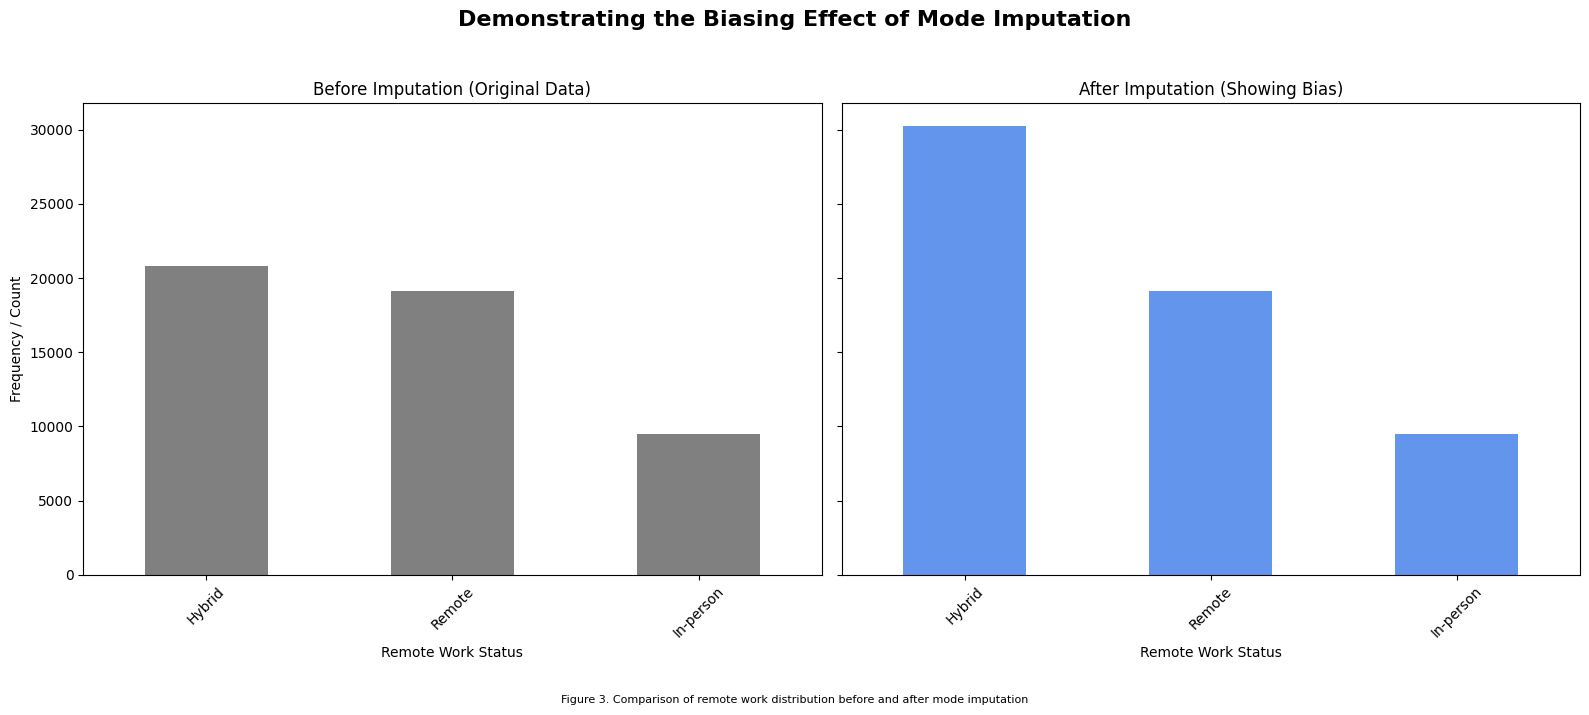

In [22]:
df_clean['RemoteWork'] = df_clean['RemoteWork'].replace('Hybrid (some remote, some in-person)', 'Hybrid') # Standardize the 'RemoteWork' column

before_counts = df_clean['RemoteWork'].value_counts() # Before data, the original value counts from df_clean

most_frequent = df_clean['RemoteWork'].mode()[0] # After data, calculate what the counts would be after mode imputation
after_counts = df_clean['RemoteWork'].fillna(most_frequent).value_counts() # .fillna() creates a new temporary Series, it does not change df_clean

# Ensure both plots have the same categories in the same order
all_categories = after_counts.index 
before_counts = before_counts.reindex(all_categories, fill_value=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), sharey=True) # Create the side-by-side subplot 

# Plot Before on the first axis
before_counts.plot(kind='bar', 
                   ax=ax1, 
                   color='gray', 
                   title='Before Imputation (Original Data)')
ax1.set_xlabel('Remote Work Status')
ax1.set_ylabel('Frequency / Count')
ax1.tick_params(axis='x', rotation=45)

# Plot After on the second axis
after_counts.plot(kind='bar', 
                  ax=ax2, 
                  color='cornflowerblue', 
                  title='After Imputation (Showing Bias)')
ax2.set_xlabel('Remote Work Status')
ax2.tick_params(axis='x', rotation=45)

# Add a main title
fig.suptitle('Demonstrating the Biasing Effect of Mode Imputation', 
             fontsize=16, 
             fontweight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for suptitle

# Add figure caption below the plot
plt.figtext(0.5, -0.01, 'Figure 3. Comparison of remote work distribution before and after mode imputation',
            ha='center', fontsize=8)
plt.show() # Show plot

**Final Decision:** I replaced missing values in `RemoteWork` with "Not Stated" rather than using mode imputation. This approach preserves the original distribution and explicitly identifies respondents who did not answer this question, avoiding the artificial inflation of any single category.

In [23]:
missing_before = df_clean['RemoteWork'].isnull().sum() # Verify missing values in df_clean before
print(f"\nMissing 'RemoteWork' values in df_clean BEFORE: {missing_before}")

if missing_before > 0:
    df_clean.loc[:, 'RemoteWork'] = df_clean['RemoteWork'].fillna('Not Stated') # Fill with 'Not Stated'
    
    missing_after = df_clean['RemoteWork'].isnull().sum() # Verify missing values in df_clean after
    print(f"Missing 'RemoteWork' values in df_clean AFTER: {missing_after}")

    print("\n--- Final 'RemoteWork' Distribution in df_clean ---")
    print(df_clean['RemoteWork'].value_counts())
else:
    print("\nNo missing values found in df_clean['RemoteWork'] to fill.")


Missing 'RemoteWork' values in df_clean BEFORE: 9422
Missing 'RemoteWork' values in df_clean AFTER: 0

--- Final 'RemoteWork' Distribution in df_clean ---
RemoteWork
Hybrid        20849
Remote        19154
In-person      9462
Not Stated     9422
Name: count, dtype: int64


The chart below shows the cleaned distribution of RemoteWork responses, including the "Not Stated" category.

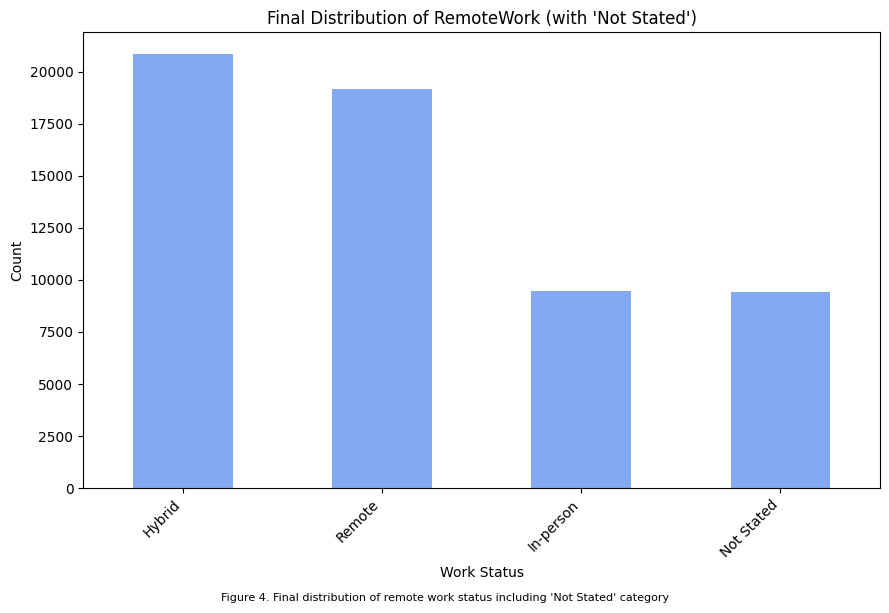

In [24]:
final_counts = df_clean['RemoteWork'].value_counts() # Count values in RemoteWork

# Create the bar chart
plt.figure(figsize=(9, 6))
final_counts.sort_values(ascending=False).plot(kind='bar', 
                                              color='cornflowerblue', 
                                              alpha=0.8)
plt.title("Final Distribution of RemoteWork (with 'Not Stated')")
plt.xlabel('Work Status')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout() # Adjust layout spacing

# Add figure caption below the plot
plt.figtext(0.5, -0.01, "Figure 4. Final distribution of remote work status including 'Not Stated' category",
            ha='center', fontsize=8)
plt.show() # Show plot

### 2.4 Handling Outliers and Missing Values in Salary Data

<div class="mathjax_ignore">
Initial examination of ConvertedCompYearly revealed significant data quality issues: 125 salaries exceeded $500K, while 2,403 were below $10K USD and 64% were missing entirely. The presence of extreme outliers and the wide range justified implementing the $10K-$500K filter to focus on typical developer compensation patterns.
</div>

In [25]:
# Analyze Raw Salary Distribution
print("--- Raw Salary Statistics ---")
print(df_clean['ConvertedCompYearly'].describe())
print("-" * 30)

# Check for Outliers
print("Checking for extreme values in raw data:")
print(f"Salaries > $500K: {(df_clean['ConvertedCompYearly'] > 500000).sum()}")
print(f"Salaries < $10K:  {(df_clean['ConvertedCompYearly'] < 10000).sum()}")
print(f"Missing values (NaN): {df_clean['ConvertedCompYearly'].isna().sum()}")


--- Raw Salary Statistics ---
count    2.343100e+04
mean     8.615578e+04
std      1.867717e+05
min      1.000000e+00
25%      3.271200e+04
50%      6.500000e+04
75%      1.079715e+05
max      1.625660e+07
Name: ConvertedCompYearly, dtype: float64
------------------------------
Checking for extreme values in raw data:
Salaries > $500K: 125
Salaries < $10K:  2403
Missing values (NaN): 35456


In [26]:
#Check the extreme values
print("Top 10 Salaries:")
display(df_clean.nlargest(10, 'ConvertedCompYearly')[['Country', 'DevType', 'YearsCodePro', 'ConvertedCompYearly']])

print("\nBottom 10 Salaries:")
display(df_clean.nsmallest(10, 'ConvertedCompYearly')[['Country', 'DevType', 'YearsCodePro', 'ConvertedCompYearly']])

Top 10 Salaries:


Country                                        DevType  \
15837      Ethiopia                                Project manager   
12723  South Africa           Senior Executive (C-Suite, VP, etc.)   
28379        Taiwan                              Hardware Engineer   
17593        Brazil                            Developer, back-end   
17672       Ukraine                              Developer, mobile   
19267         India                           Developer, front-end   
23694      Pakistan  Developer, desktop or enterprise applications   
33720        Brazil                          Developer, full-stack   
34523      Pakistan                           Developer, front-end   
13763     Australia                          Developer, full-stack   

      YearsCodePro  ConvertedCompYearly  
15837            5           16256603.0  
12723           10           13818022.0  
28379            7            9000000.0  
17593           13            6340564.0  
17672           11            4936778.0  
19267            7            3367716.0  
23694            5            2584118.0  
33720            5            2237846.0  
34523            2            2153432.0  
13763           12            2048046.0


Bottom 10 Salaries:


Country                DevType        YearsCodePro  \
3890         France  Developer, full-stack                   6   
5069   Sierra Leone  Developer, full-stack                   3   
6102       Colombia  Developer, full-stack                   3   
6963            USA  Developer, full-stack                  18   
7773       Viet Nam  Developer, full-stack                  12   
10678       Ukraine    Developer, back-end                  10   
20888      Viet Nam          Data engineer                   6   
22245   Afghanistan          Data engineer  More than 50 years   
24247       Nigeria  Developer, full-stack                   5   
25200   Afghanistan             Blockchain                 NaN   

       ConvertedCompYearly  
3890                   1.0  
5069                   1.0  
6102                   1.0  
6963                   1.0  
7773                   1.0  
10678                  1.0  
20888                  1.0  
22245                  1.0  
24247                  1.0  
25200                  1.0

To understand the nature of outliers, I examined the highest and lowest reported salaries:

**High outliers** (>500,000 USD): The top 10 salaries ranged from 2M to 16M and appeared to contain data quality issues rather than legitimate compensation. For example, figures like $9M for a hardware engineer in Taiwan, that likely represent currency conversion errors or data entry mistakes.

**Low outliers** (<10,000 USD): The bottom salaries were predominantly $1 annual compensation, reported by developers with varying experience levels (3-18 years) across multiple countries, likely representing incomplete responses.

Rows before filtering: 58887
Rows after filtering: 20903

Salary range: $10,000 - $500,000

New salary statistics:
count     20903.000000
mean      88212.431134
std       65183.586504
min       10000.000000
25%       43616.000000
50%       72231.000000
75%      114358.000000
max      500000.000000
Name: ConvertedCompYearly, dtype: float64


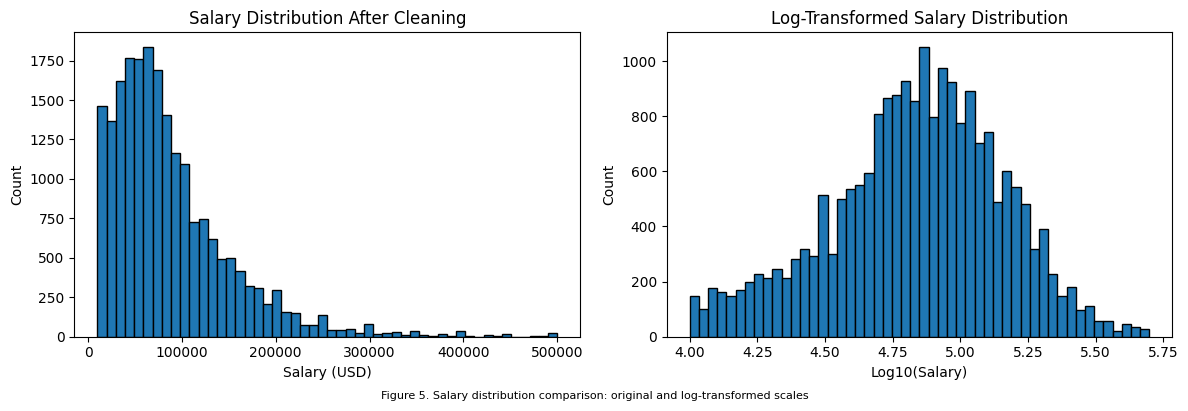

In [27]:
# Salary bounds
LOWER_BOUND = 10000
UPPER_BOUND = 500000

print(f"Rows before filtering: {len(df_clean)}")

# Filter salaries within the specified range
df_salary_range = df_clean[
    (df_clean['ConvertedCompYearly'] >= LOWER_BOUND) &
    (df_clean['ConvertedCompYearly'] <= UPPER_BOUND)].copy()

print(f"Rows after filtering: {len(df_salary_range)}")
print(f"\nSalary range: ${df_salary_range['ConvertedCompYearly'].min():,.0f} - ${df_salary_range['ConvertedCompYearly'].max():,.0f}\n")
print(f"New salary statistics:\n{df_salary_range['ConvertedCompYearly'].describe()}")

#Visualize salary distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df_salary_range['ConvertedCompYearly'], bins=50, edgecolor='black')
plt.xlabel('Salary (USD)')
plt.ylabel('Count')
plt.title('Salary Distribution After Cleaning')

plt.subplot(1, 2, 2)
plt.hist(np.log10(df_salary_range['ConvertedCompYearly']), bins=50, edgecolor='black')
plt.xlabel('Log10(Salary)')
plt.ylabel('Count')
plt.title('Log-Transformed Salary Distribution')
plt.tight_layout() # Adjust layout spacing

# Add figure caption below the plot
plt.figtext(0.5, -0.01, 'Figure 5. Salary distribution comparison: original and log-transformed scales',
            ha='center', fontsize=8)
plt.show() # Show plot

<div class="mathjax_ignore">
The salary filter retained 20,903 responses (35.5% of the original dataframe) with a median of $72,231 and mean of $88,212. The distribution shows typical income skewness, with half of developers earning between $44K and $114K.
<br><br>
The log-transformed view (Figure 5; right panel) reveals a more symmetric, approximately normal distribution. This transformation is particularly useful for subsequent correlation and regression analyses, as it addresses the right skewness inherent in salary data and stabilizes variance across the income range.
</div>

#### 2.4.1 Career Experience Variables

To analyze salary relationships with experience and role, I cleaned three critical variables in `df_salary_range`:

* **DevType:** Developer role classifications
* **YearsCodePro:** Professional coding experience
* **YearsCode:** Total coding experience (including hobby and education)

These variables required standardization and validation to ensure accurate compensation analysis.

In [28]:
df_salary_range['YearsCodePro'].unique()

array(['6', '17', '7', '18', '25', '30', '20', '50', '27', '16', '1', '4',
       '15', '11', '23', '10', '9', '8', '24', '12', '26', '40', '14',
       '22', '5', '28', '44', '42', '13', '19', '3', '35', '31', '41',
       '36', 'Less than 1 year', '2', nan, '38', '32', '34', '21',
       'More than 50 years', '29', '45', '43', '33', '48', '37', '39',
       '46', '49', '47'], dtype=object)

In [29]:
# Extract only the digits from the 'YearsCodePro' and 'YearsCode' string and then convert the extracted string numbers into a numeric type
df_salary_range['YearsCodePro'] = df_salary_range['YearsCodePro'].str.extract(r'(\d+)').astype(float)
df_salary_range['YearsCode'] = df_salary_range['YearsCode'].str.extract(r'(\d+)').astype(float)

In [30]:
# Apply the mapping
df_salary_range['DevType_clean'] = df_salary_range['DevType'].replace(devlevel_map) # The .replace() function applies the dictionary mapping to the 'DevType' column

# Verify the results
print("Displaying top 10 values counts for the new 'DevType_clean' column:")
print(df_salary_range['DevType_clean'].value_counts().head(10)) # Using .value_counts() to check the distribution of the new, clean categories

Displaying top 10 values counts for the new 'DevType_clean' column:
DevType_clean
Full-stack            7346
Back-end              4258
Front-end             1162
Desktop/Enterprise     976
Embedded               705
Mobile                 671
Other                  630
Data Engineer          536
Eng. MGR               511
DevOps                 453
Name: count, dtype: int64


### 2.5 Feature Engineering

#### 2.5.1 Creating Numeric Age Variable

I converted categorical age ranges to numeric values using range midpoints (e.g., "25-34 years old" to 29.5), with fixed values for edge cases: 18 for "Under 18" and 65 for "65 years or older." Respondents who selected "Prefer not to say" were treated as missing data.

The transformed variable shows a mean age of 33 years, reflecting a relatively young developer population.

In [31]:
print("\nUnique values in 'Age' column:")
print(df_clean['Age'].unique())


Unique values in 'Age' column:
['Under 18 years old' '35-44 years old' '45-54 years old'
 '18-24 years old' '25-34 years old' '55-64 years old' 'Prefer not to say'
 '65 years or older']


In [32]:
def process_age_string(age_text):
    # Converts an age range string (e.g., '25-34 years old') into an approximate numerical age.
    if pd.isna(age_text) or age_text == 'Prefer not to say':
        return np.nan

    numbers = re.findall(r'\d+', age_text) # Find all numbers in the string

    # Case 1: Range (e.g., "25-34")
    if len(numbers) == 2:
        num1 = int(numbers[0])
        num2 = int(numbers[1])
        return (num1 + num2) / 2 # Return the average
    
    # Case 2: Single number (e.g., "Under 18" or "65 or older")
    elif len(numbers) == 1:
        num = int(numbers[0])
        if 'Under' in age_text:
            return 18 # Use 18 as a fixed value
        elif 'older' in age_text:
            return 65 # Use 65 as a fixed value

    return np.nan # Fallback for any other cases

In [33]:
df_clean.loc[:, 'Age_Numeric'] = df_clean['Age'].apply(process_age_string)

mean_age = df_clean['Age_Numeric'].mean()
print(f"\nThe approximate average age of respondents is: {mean_age:.0f} years")


The approximate average age of respondents is: 33 years


#### 2.5.2 Technology Range Metrics

I created count based features from multi select technology columns to measure skill range. Each feature counts the number of technologies a developer reported using, treating missing values as zero:

* **Num_Languages:** Programming languages
* **Num_Database:** Database technologies
* **Num_Platforms:** Cloud/platform technologies
* **Num_Webframes:** Web frameworks
* **Num_Tools:** Development tools
* **Total_Skills:** Combined count across all categories

In [34]:
# Count features for all tech stack columns
print("Creating count features for multi-select columns...")

# Use .str.split(';').str.len() which counts the items,
# .fillna(0) to convert all NaN (missing) values to 0 and
# .astype(int) to make the columns clean integers

# Language
df_clean['Num_Languages'] = df_clean['LanguageHaveWorkedWith'].str.split(';').str.len().fillna(0).astype(int)

# Database
df_clean['Num_Database'] = df_clean['DatabaseHaveWorkedWith'].str.split(';').str.len().fillna(0).astype(int)

# Plataforms
df_clean['Num_Platforms'] = df_clean['PlatformHaveWorkedWith'].str.split(';').str.len().fillna(0).astype(int)

# Web Frameworks
df_clean['Num_Webframes'] = df_clean['WebframeHaveWorkedWith'].str.split(';').str.len().fillna(0).astype(int)

# Tools
df_clean['Num_Tools'] = df_clean['ToolsTechHaveWorkedWith'].str.split(';').str.len().fillna(0).astype(int)

# Check the new features
print("\nCount feature statistic:")
count_cols = ['Num_Languages', 'Num_Database', 'Num_Platforms', 'Num_Webframes', 'Num_Tools']
display(df_clean[count_cols].describe())

# Create a "total skills" feature
df_clean['Total_Skills'] = (
    df_clean['Num_Languages'] +
    df_clean['Num_Database'] +
    df_clean['Num_Platforms'] +
    df_clean['Num_Webframes'] +
    df_clean['Num_Tools']
)

print("\nTotal Skills distribution:")
print(df_clean['Total_Skills'].describe())

# Quick correlation check with salary
print("\nCorrelation with salary:")
correlation_data = df_clean[count_cols + ['Total_Skills', 'ConvertedCompYearly']].corr()['ConvertedCompYearly'].sort_values()
print(correlation_data)

Creating count features for multi-select columns...

Count feature statistic:


Num_Languages  Num_Database  Num_Platforms  Num_Webframes     Num_Tools
count   58887.000000  58887.000000   58887.000000   58887.000000  58887.000000
mean        5.290879      2.534685       1.634198       2.608403      3.881808
std         3.360609      2.371455       1.894024       2.732401      3.107258
min         0.000000      0.000000       0.000000       0.000000      0.000000
25%         3.000000      1.000000       0.000000       0.000000      2.000000
50%         5.000000      2.000000       1.000000       2.000000      3.000000
75%         7.000000      4.000000       2.000000       4.000000      6.000000
max        49.000000     35.000000      27.000000      36.000000     34.000000


Total Skills distribution:
count    58887.000000
mean        15.949972
std         10.609448
min          0.000000
25%          9.000000
50%         14.000000
75%         21.000000
max        181.000000
Name: Total_Skills, dtype: float64

Correlation with salary:
Num_Webframes         -0.040781
Num_Database          -0.010452
Total_Skills          -0.003012
Num_Languages          0.002852
Num_Tools              0.018689
Num_Platforms          0.021156
ConvertedCompYearly    1.000000
Name: ConvertedCompYearly, dtype: float64


**Results and Interpretation**

The analysis of the engineered count features reveals two key insights. 

* First, the median developer knows 5 programming languages, 2 databases, 1 platform, 2 web frameworks, and 3 tools, with a median of 14 total skills.

* **Key Finding:** Contrary to expectations, skill range shows no correlation with salary. All count variables have correlations near zero with ConvertedCompYearly, with Total_Skills at -0.003 and the highest Num_Platforms at 0.021. This reveals that knowing more technologies does not translate to higher compensation.

### 2.6 Correlation Analysis: Salary, Job Satisfaction and Experience

I examined correlations between key numerical variables in the salary dataset to identify relationships between compensation, experience, and job satisfaction (Figure 6).

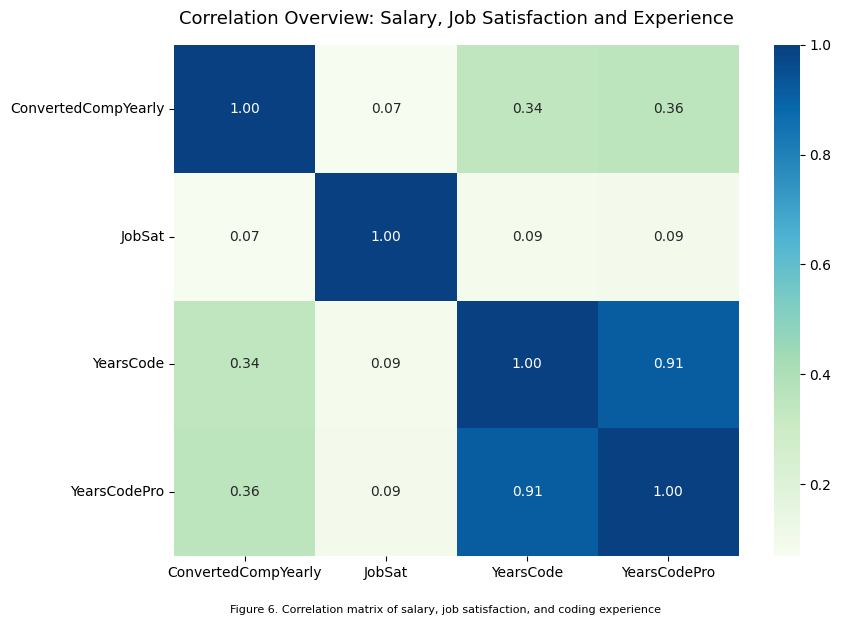

In [35]:
columns_corr = ['ConvertedCompYearly', 'JobSat', 'YearsCode', 'YearsCodePro'] # Columns for correlation analysis
corr_df = df_salary_range[columns_corr].dropna() # Drop rows with missing values

# Create the Plot
plt.figure(figsize=(9, 6))
sns.heatmap(
    corr_df.corr(), 
    annot=True, 
    cmap='GnBu', 
    fmt=".2f")
plt.title("Correlation Overview: Salary, Job Satisfaction and Experience", fontsize=13, pad=15)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout() # Adjust layout spacing

# Add figure caption below the plot
plt.figtext(0.5, -0.03, 'Figure 6. Correlation matrix of salary, job satisfaction, and coding experience',
            ha='center', fontsize=8)
plt.show() # Show plot

* **Experience and salary:** Professional experience (YearsCodePro) shows a moderate positive correlation with salary (r = 0.36), indicating that developers with more experience tend to earn higher compensation. Total coding experience (YearsCode) shows a similar pattern (r = 0.34).

* **Experience metrics:** YearsCode and YearsCodePro are highly correlated (r = 0.91), as both measure programming experience, though the former includes hobby and educational coding.

* **Job satisfaction:** Notably, JobSat shows weak or negligible correlations with both salary (r = 0.07) and experience (r = 0.09), suggesting that compensation and career are not strong predictors of job satisfaction in this dataset.

These patterns inform subsequent analyses: experience is a relevant factor in compensation models, while job satisfaction analysis requires examining other factors such as work environment, role, and company culture.

### 2.7 Dataset Summary

At the end of the preparation phase, our data is ready for analysis. I have created two datasets:

* **df_clean** (58,887 rows): This is my primary DataFrame. I removed duplicates and cleaned key categorical features (EdLevel, DevType, Country, RemoteWork), imputing missing values with "Not Stated" to avoid data loss. I also engineered a new Age_Numeric feature for correlation analysis.

* **df_salary_range** (20,903 rows): This is a specialized subset of df_clean created specifically for salary related analysis. It includes only respondents who provided a salary between 10,000 and 500,000 USD, filtering out extreme or potentially invalid values to ensure compensation insights are based on reliable data.

---

## 3. Key Findings & Results

### Finding 1: The 2024 Developer Profile

To understand who participates in the global developer community, I analyzed demographic patterns including geographic distribution, age, education, and work arrangements.

#### 3.1 Global Developer Distribution

I visualized geographic distribution using a bubble map where bubble size represents respondent count, avoiding the distortion of traditional maps where large countries appear more prominent regardless of developer population.

/var/folders/f4/m8pxl6716xzdb3nlp9d43gb80000gn/T/ipykernel_51933/94542630.py:6: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



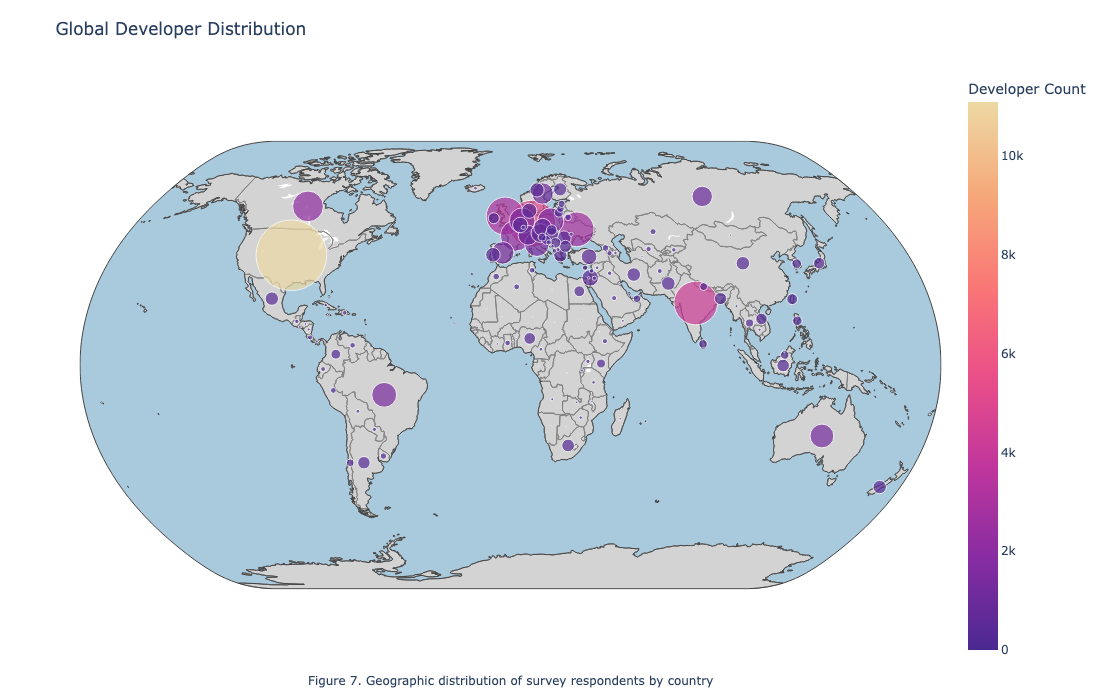

In [36]:
country_counts = df_clean['Country'].value_counts() # Count how many times each country appears
country_counts_df = country_counts.reset_index() # Convert to a DataFrame
country_counts_df.columns = ['Country', 'Developer Count'] # Rename the columns

# Create Map
fig = px.scatter_geo(
    data_frame=country_counts_df,
    locations="Country",
    locationmode="country names",
    size="Developer Count",
    size_max=50,
    color="Developer Count",
    hover_name="Country",
    hover_data={"Developer Count": True, "Country": False},
    color_continuous_scale='agsunset',
    title="Global Developer Distribution",
    projection='natural earth')

# Layout adjustments
fig.update_layout(
    width=1100,
    height=700,
    margin=dict(l=80, r=80, t=70, b=40)) # Increased bottom margin for caption

# Map styling
fig.update_geos(
    showland=True,
    landcolor="lightgray",
    showocean=True,
    oceancolor="#A9C9DD",
    showcountries=True,
    countrycolor="gray",)

# Add figure caption below the plot
fig.add_annotation(
    text="Figure 7. Geographic distribution of survey respondents by country",
    xref="paper", yref="paper", x=0.5, y=-0.05, showarrow=False, font=dict(size=12), xanchor='center')

fig.show() # Show plot

The survey captured developers from 182 countries, with the United States leading at 11,095 respondents, followed by Germany (4,947) and India (4,231).

While heavily concentrated in established tech markets in North America and Europe, the dataset includes representation from emerging tech regions across Asia, Latin America, and Africa. This geographic diversity enables comparative analysis of regional trends in technology adoption, compensation patterns, and work practices, though findings are most robust for well represented countries.

#### 3.2 Top 10 Countries by Developers

I created a horizontal bar chart to highlight the countries with the highest participation, with percentages shown for context.

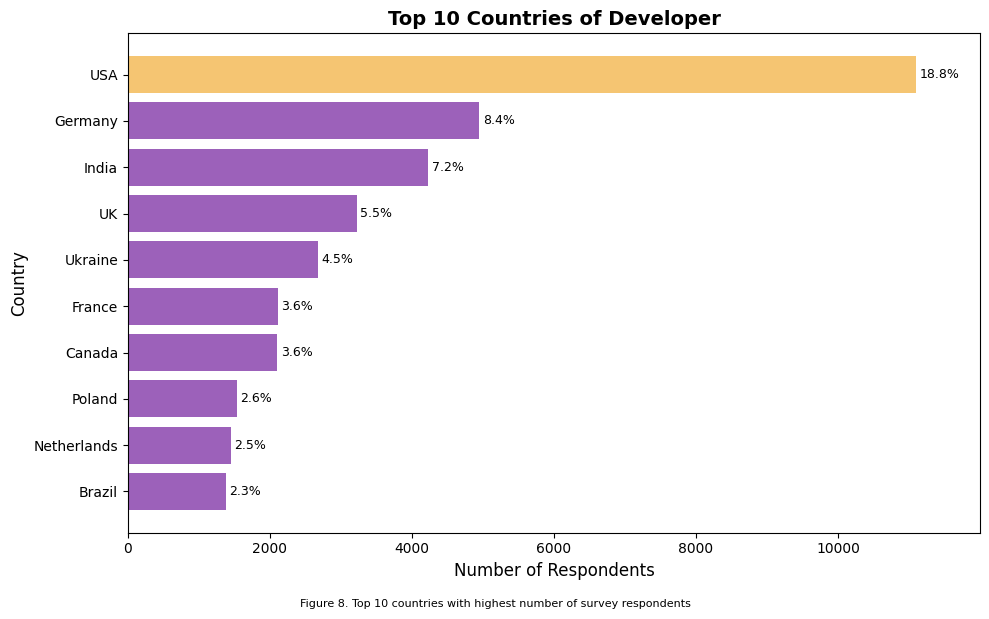

In [37]:
top_countries = df_clean['Country'].value_counts().head(10) # Get the top 10 countries
top_countries = top_countries[::-1] # Reverse the order so that the highest is displayed at the top

total_respondents = df_clean['Country'].count() # Calculate the total number of respondents for percentage calculation

# Create a color list: default color for all, highlight color for the top one
colors = ["#9c61ba"] * len(top_countries)
colors[-1] = "#f5c572"

# Create the Plot
plt.figure(figsize=(10,6))
plt.barh(top_countries.index, top_countries.values, color=colors)
plt.title('Top 10 Countries of Developer', fontsize=14, fontweight='bold')
plt.xlabel('Number of Respondents', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.xlim(0,11999)

# Add value labels to each bar as a percentage
for i, v in enumerate(top_countries.values):
    pct_label = f'{(v / total_respondents) * 100:.1f}%'
    plt.text(v + 50, i, pct_label, va='center', fontsize=9)

plt.tight_layout() # Adjust layout spacing

# Add figure caption below the plot
plt.figtext(0.5, -0.02, 'Figure 8. Top 10 countries with highest number of survey respondents',
            ha='center', fontsize=8)
plt.show() # Show plot

The top 10 countries collectively represent 59% of all survey responses. The United States leads at 18.8%, followed by Germany at 8.4% and India at 7.2%. The remaining seven countries each contribute between 2.3% and 5.5% of responses.

This concentration in North America and Europe reflects both the survey's reach in established tech markets and Stack Overflow's user base demographics.

#### 3.3 Education Level of Respondents

I visualized the distribution of formal education levels using a horizontal bar chart ordered from lowest to highest degree.

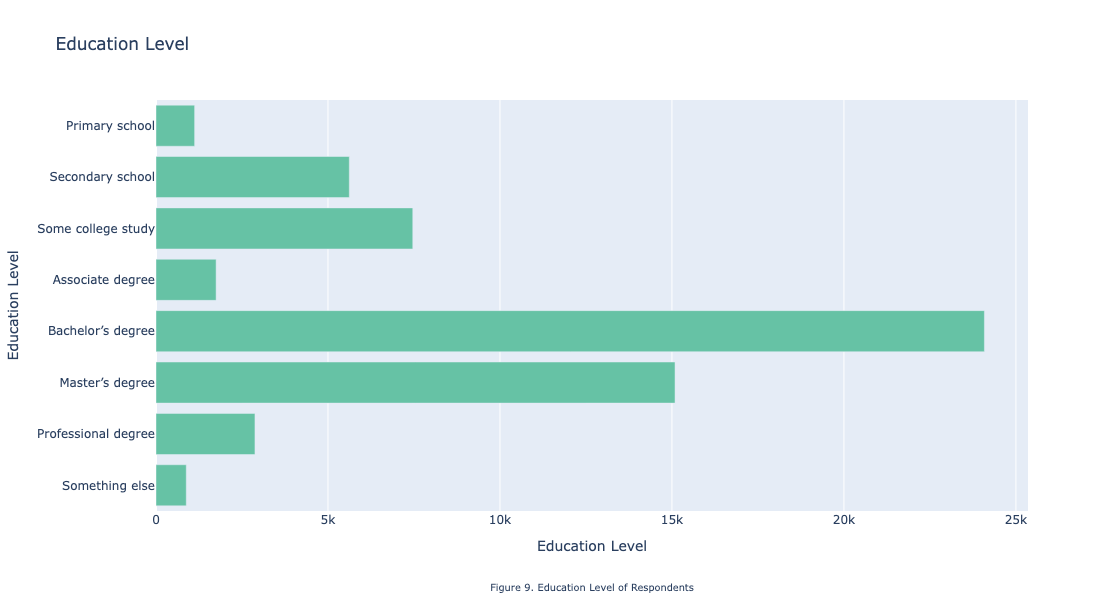

In [38]:
ed_counts = df_clean['EdLevel_clean'].value_counts().reset_index() # Get the counts of each unique value in the 'EdLevel_clean' column
ed_counts.columns = ['EdLevel_clean', 'count'] # Rename the columns for clarity
total_respondents = ed_counts['count'].sum() # Calculate the total number of respondents by summing the 'count' column
ed_counts['percentage'] = (ed_counts['count'] / total_respondents) # Create a new 'percentage' column

# Sort categories by age
ed_order = [
    "Primary school", "Secondary school", "Some college study", "Associate degree", 
    "Bachelor’s degree", "Master’s degree", "Professional degree", "Something else"]

# Create the Plot
fig = px.bar(
    ed_counts, 
    x='count',           
    y='EdLevel_clean',
    title='Education Level',
    custom_data=['EdLevel_clean', 'count', 'percentage'],
    labels={
        'count': 'Number of Respondents',
        'EdLevel_clean': 'Education Level'},
    category_orders={'EdLevel_clean': ed_order},
    color_discrete_sequence=px.colors.qualitative.Set2)

# Layout adjustments
fig.update_layout(
    width=1000,
    height=600)

# Use fig.update_traces to define the template of the hover
fig.update_traces(
    hovertemplate =(
        "<b>%{customdata[0]}</b><br>" + 
        "<br>Percentage: %{customdata[2]:.0%}<br>" +
        "<br>(%{customdata[1]:,.0f} responses)" +
        "<extra></extra>"))

fig.update_xaxes(title_text='Education Level<br><br><sub>Figure 9. Education Level of Respondents</sub>') # Add caption below x-axis title
fig.show() # Show plot

**The developer community is highly educated:** Bachelor's degrees are most common at 41%, followed by Master's degrees at 26%. Combined, undergraduate and graduate degree holders represent nearly 70% of respondents.

Respondents with some college (13%) or secondary school education (10%) form smaller segments, while professional degrees, associate degrees, and primary school education each account for less than 5% of the sample. This educational profile reflects the technical nature of software development and the academic pathways commonly associated with entering the field.

#### 3.4 Learning Methods Across Age Groups

I visualized how developers learned to code across different age groups using a grouped histogram to reveal generational shifts in coding education.

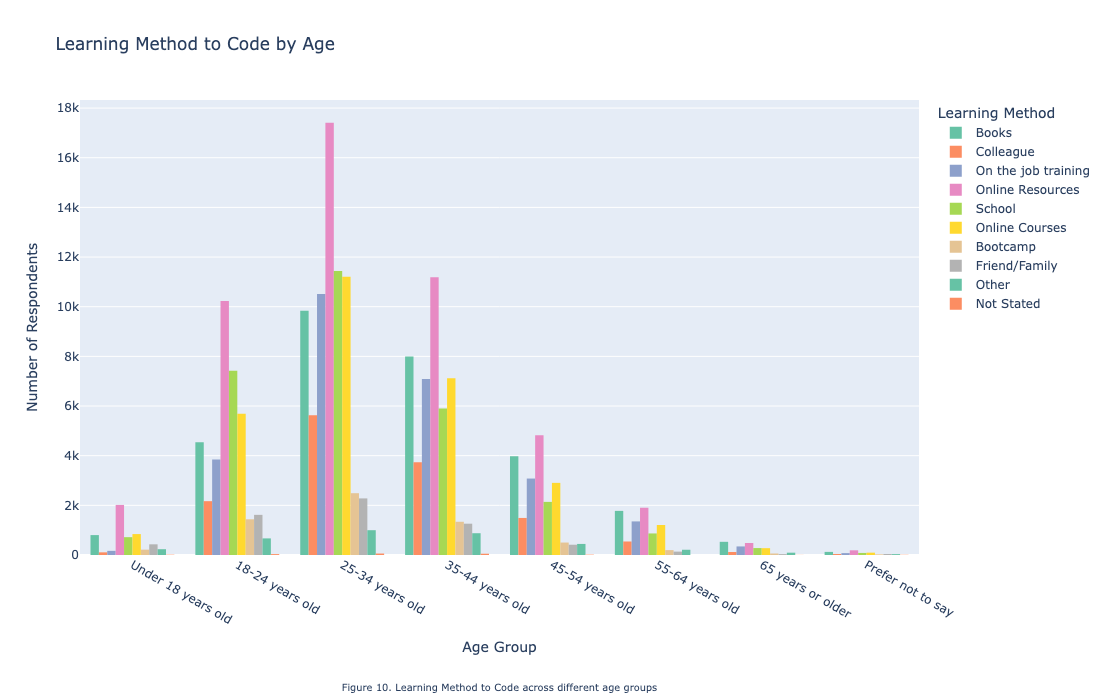

In [39]:
df_age_learn = df_clean[['Age', 'LearnCode']].fillna({'LearnCode': 'Not Stated'}) # Create a temporary DataFrame
df_age_learn['LearnCode'] = df_age_learn['LearnCode'].str.split(';') # Split the ‘LearnCode’ column
df_age_learn = df_age_learn.explode('LearnCode') # Explode the DataFrame
df_age_learn['LearnCode'] = df_age_learn['LearnCode'].str.strip() # Clean blank spaces

# Sort categories by age
age_order = [
    'Under 18 years old', '18-24 years old', '25-34 years old', '35-44 years old', 
    '45-54 years old', '55-64 years old', '65 years or older', 'Prefer not to say']

# Define the mapping, descriptive strings to shorter, standardized ones
learn_code = {
    'Books / Physical media': 'Books',
    'Other online resources (e.g., videos, blogs, forum, online community)': 'Online Resources',
    'School (i.e., University, College, etc)': 'School',
    'Online Courses or Certification': 'Online Courses',
    'Coding Bootcamp': 'Bootcamp',
    'Friend or family member': 'Friend/Family',
    'Other (please specify):': 'Other',}

# Apply the mapping
df_age_learn['LearnCode'] = df_age_learn['LearnCode'].apply(lambda x: learn_code.get(x, x))

# Create the Plot
fig = px.histogram(
    df_age_learn,
    x='Age', 
    color='LearnCode',
    title='Learning Method to Code by Age',
    labels={'Age': 'Age Group', 'LearnCode': 'Learning Method'},
    barmode='group',
    category_orders={'Age': age_order},
    color_discrete_sequence=px.colors.qualitative.Set2)

# Layout adjustments
fig.update_layout(
    width=1100,
    height=700,
    xaxis_title="Age Group",
    yaxis_title="Number of Respondents")

# Use fig.update_traces to define the template of the hover
fig.update_traces( 
    hovertemplate =(
        "<b>%{fullData.name}</b><br>" +
        "<br>%{x}" +
        "<br>(%{y:,.0f} responses)" +
        "<extra></extra>"))

fig.update_xaxes(title_text='Age Group<br><br><sub>Figure 10. Learning Method to Code across different age groups</sub>') # Add caption below x-axis title
fig.show() # Show plot

Online resources dominate as the primary learning method across all age groups, peaking among developers aged 25-34 (17,409 responses). However, clear generational patterns emerge:

* **18-24 years:** Higher reliance on formal schooling, reflecting increased computer science education in recent years.
* **25-34 years:** Peak online resource usage, coinciding with the rise of platforms like Stack Overflow, YouTube tutorials, and free coding resources.
* **55+ years:** Significant decline in participation, representing a smaller group in the developer workforce.

This distribution reflects the democratization of coding education through free online resources, while also showing how learning pathways vary by generation based on available technologies during formative career years.

#### 3.5 Remote Work Status by Developer Role

I created a stacked bar chart showing the distribution of work arrangements (Hybrid, Remote, In-person, Not Stated) across the top 10 developer roles, with less common roles grouped as "Remaining Roles."

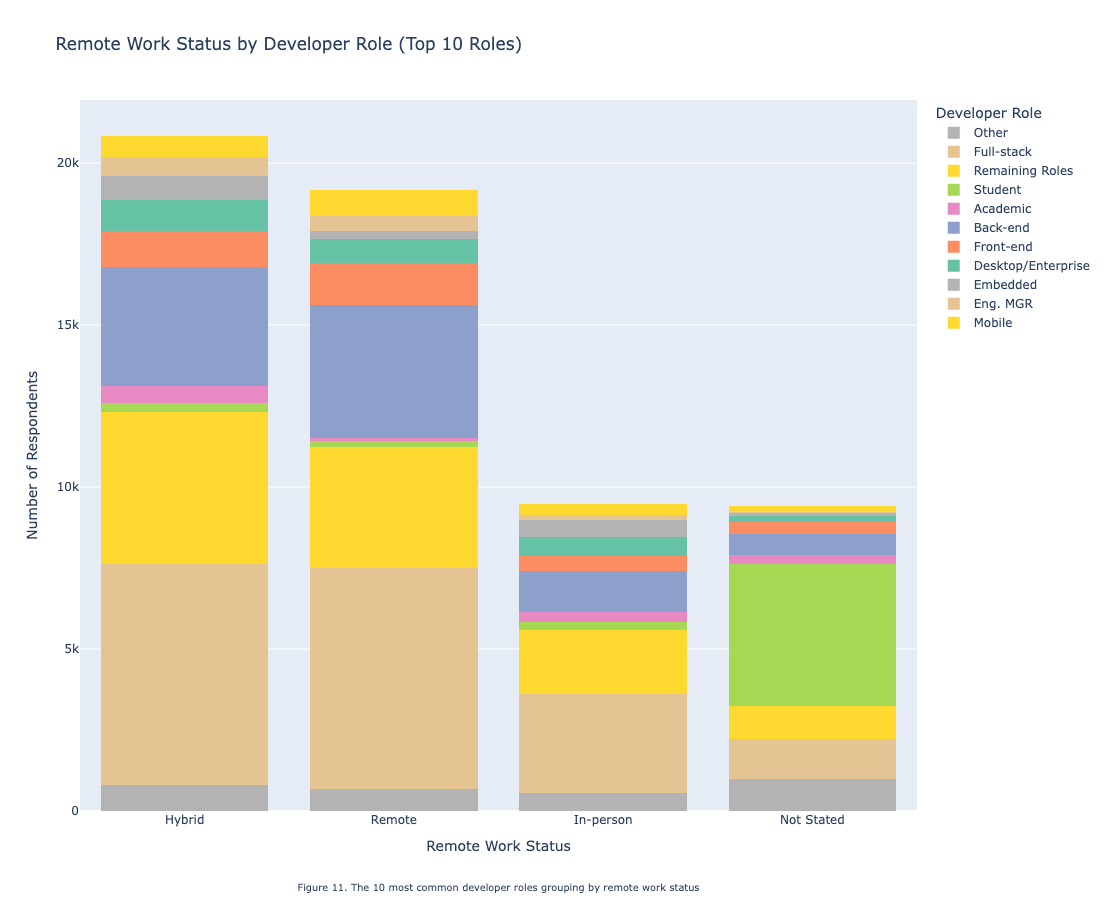

In [40]:
top_10_roles = df_clean['DevType_clean'].value_counts().head(10).index.tolist() # Get the 10 most common developer roles

# Create a new column 'DevType_Simple'
# If a role is not in the top 10, label it as 'Remaining Roles'
df_clean['DevType_Simple'] = df_clean['DevType_clean'].apply(lambda x: x if x in top_10_roles else 'Remaining Roles')

# Define the desired order for RemoteWork categories
rol_order = ['Hybrid', 'Remote', 'In-person', 'Not Stated']

# Create the Plot
fig = px.histogram(
    df_clean,
    x='RemoteWork',
    color='DevType_Simple',
    title='Remote Work Status by Developer Role (Top 10 Roles)',
    labels={
        'RemoteWork': 'Remote Work Status',
        'DevType_Simple': 'Developer Role'},
    barmode='stack',
    category_orders={'RemoteWork': rol_order},
    color_discrete_sequence=px.colors.qualitative.Set2_r)

# Layout adjustments
fig.update_layout(
    width=1000,
    height=900,
    xaxis_title="Remote Work Status",
    yaxis_title="Number of Respondents")

# Use fig.update_traces to define the template of the hover
fig.update_traces(
    hovertemplate =(
        "<b>%{fullData.name}</b><br>" + 
        "<br>Work Status: %{x}" +
        "<br>(%{y:,.0f} responses)" +
        "<extra></extra>"))

fig.update_xaxes(title_text='Remote Work Status<br><br><sub>Figure 11. The 10 most common developer roles grouping by remote work status</sub>') # Add caption below x-axis title
fig.show() # Show plot

Hybrid work is the most common arrangement with over 20,000 respondents, followed closely by remote work. Full-stack developers represent the largest group in both hybrid and remote categories. Notably, the distribution of developer roles remains remarkably consistent across hybrid and remote status. 

Work arrangement appears driven more by company policy and individual preference than by technical role requirements.

### Finding 2: The Developer's Toolkit

Having established who developers are, I now examine the tools they use. This section analyzes which technologies are most popular, which are most desired, and how developers combine them in their work.

#### 3.6 Top 15 Programming Languages: Current Usage vs. Desired

I created a side by side horizontal bar chart comparing the languages developers currently use with those they want to work with, revealing gaps between present practice and future interest.

In [41]:
# Helper function to process multi select columns
def get_top_n(df, column, n):
    #Splits, explodes, and counts values in a semicolon-separated column, then returns the top N results.
    df_col = df[column].dropna() # Drop NaNs to avoid errors
    counts = df_col.str.split(';').explode().value_counts() # Split, explode, and count
    return counts.head(n) # Return the top N

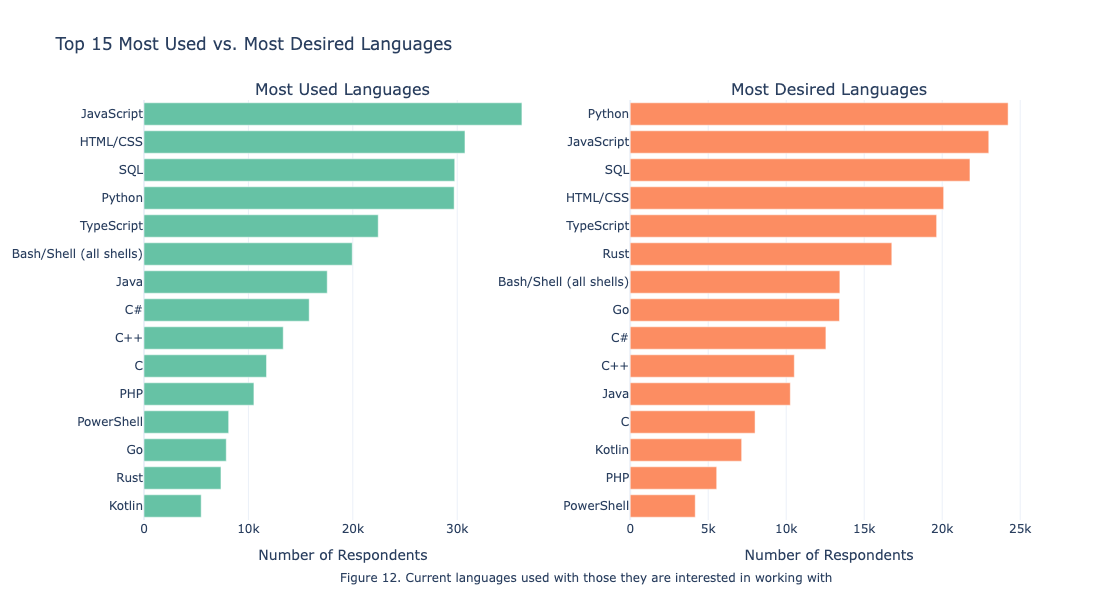

In [42]:
total_respondents = len(df_clean) # Get total respondent count

top_used_lang = get_top_n(df_clean, 'LanguageHaveWorkedWith', 15) # Get top 15 most used languages (using a custom function)
top_desired_lang = get_top_n(df_clean, 'LanguageWantToWorkWith', 15) # Get top 15 most desired languages

top_used_lang_pct = (top_used_lang / total_respondents) # Convert the 'used' counts to percentages
top_desired_lang_pct = (top_desired_lang / total_respondents) # Convert the 'desired' counts to percentages

# Create a figure with two subplots side by side
fig = make_subplots(
    rows=1, 
    cols=2,
    subplot_titles=('Most Used Languages', 'Most Desired Languages'))

fig.add_trace(
    go.Bar(
        x=top_used_lang.values, y=top_used_lang.index,
        orientation='h', name='Used Languages',
        marker_color=px.colors.qualitative.Set2[0],
        customdata=top_used_lang_pct.values,
        hovertemplate=(
            "<b>%{y}</b><br>" +
            "Percentage: %{customdata:.1%}<br>" +
            "(%{x:,.0f} responses)" +
            "<extra></extra>")),
    row=1, col=1)

fig.add_trace(
    go.Bar(
        x=top_desired_lang.values, y=top_desired_lang.index,
        orientation='h', name='Desired Languages',
        marker_color=px.colors.qualitative.Set2[1],
        customdata=top_desired_lang_pct.values,
        hovertemplate=(
            "<b>%{y}</b><br>" +
            "Percentage: %{customdata:.1%}<br>" +
            "Respondents: %{x:,.0f}" +
            "<extra></extra>")),
    row=1, col=2)

# Layout adjustments
fig.update_layout(
    title_text='Top 15 Most Used vs. Most Desired Languages',
    height=600,
    width=1100,
    showlegend=False, 
    template='plotly_white')

# Order both Y axes to display the longest bar at the top
fig.update_yaxes(categoryorder='total ascending', row=1, col=1)
fig.update_yaxes(categoryorder='total ascending', row=1, col=2)

# Axis labeling
fig.update_xaxes(title_text='Number of Respondents', row=1, col=1)
fig.update_xaxes(title_text='Number of Respondents', row=1, col=2)
fig.add_annotation(
    text="Figure 12. Current languages used with those they are interested in working with",
    align='center', showarrow=False, xref='paper', yref='paper', x=0.5, y=-0.16)
fig.show() # Show plot

The comparison between most used and most desired languages reveals evolving developer preferences. While JS leads in current usage, Python tops the desired list, climbing from 4th place indicating strong interest in its applications for data science and automation. 

The most dramatic shift appears in Rust and Go, which rank near the bottom in usage but surge to 6th and 8th in desirability, reflecting growing demand for modern systems languages.

Meanwhile, foundational technologies like JS, SQL, and HTML/CSS maintain their dominance across both lists. 

This gap between current usage and desire indicates where the industry is heading: toward data driven applications (Python), modern systems programming (Rust/Go), and performance critical backends.

#### 3.7 Top 15 Database: Current Usage vs. Desired

I compare database usage with developer interest using the same methodology as the previous section.

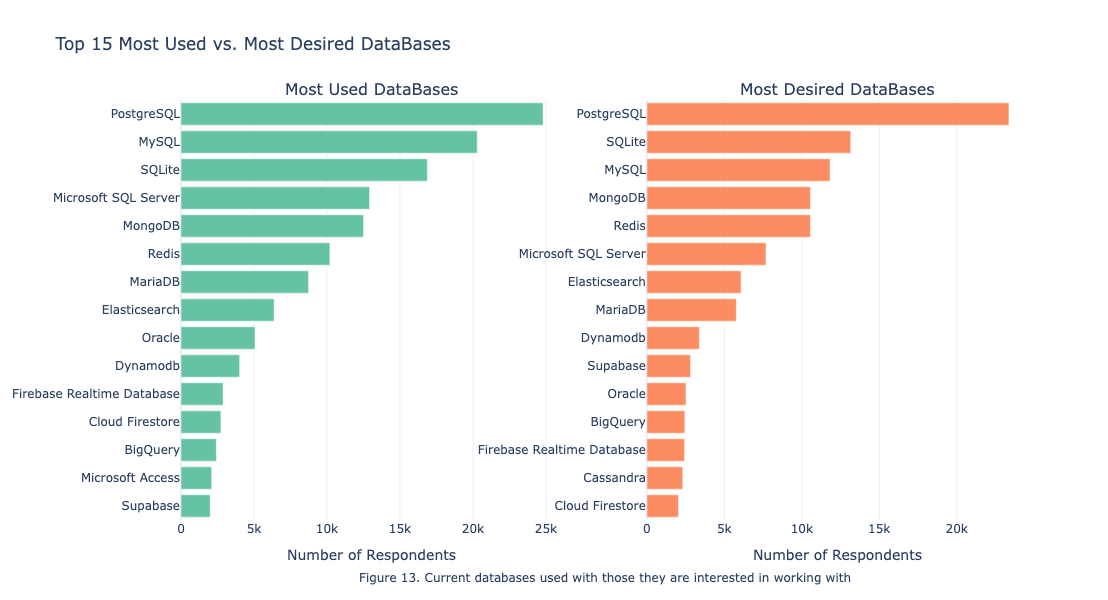

In [43]:
top_used_datbas = get_top_n(df_clean, 'DatabaseHaveWorkedWith', 15) # Get top 15 most used databases
top_desired_datbas = get_top_n(df_clean, 'DatabaseWantToWorkWith', 15) # Get top 15 most desired databases

top_used_datbas_pct = (top_used_datbas / total_respondents) # Convert the 'used' counts to percentages
top_desired_datbas_pct = (top_desired_datbas / total_respondents) # Convert the 'desired' counts to percentages

# Create a figure with two subplots side-by-side
fig = make_subplots(
    rows=1, 
    cols=2,
    subplot_titles=('Most Used DataBases', 'Most Desired DataBases'))

fig.add_trace(
    go.Bar(
        x=top_used_datbas.values, y=top_used_datbas.index,
        orientation='h',name='Used DataBases',
        marker_color=px.colors.qualitative.Set2[0],
        customdata=top_used_datbas_pct.values,
        hovertemplate=(
            "<b>%{y}</b><br>" +
            "Percentage: %{customdata:.1%}<br>" +
            "(%{x:,.0f} responses)" +
            "<extra></extra>")),
    row=1, col=1)

fig.add_trace(
    go.Bar(
        x=top_desired_datbas.values, y=top_desired_datbas.index,
        orientation='h', name='Desired DataBases',
        marker_color=px.colors.qualitative.Set2[1],
        customdata=top_desired_datbas_pct.values,
        hovertemplate=(
            "<b>%{y}</b><br>" +
            "Percentage: %{customdata:.1%}<br>" +
            "(%{x:,.0f} responses)" +
            "<extra></extra>")),
    row=1, col=2)

# Layout adjustments
fig.update_layout(
    title_text='Top 15 Most Used vs. Most Desired DataBases',
    height=600,
    width=1100,
    showlegend=False, 
    template='plotly_white')

# Order both Y axes to display the longest bar at the top
fig.update_yaxes(categoryorder='total ascending', row=1, col=1)
fig.update_yaxes(categoryorder='total ascending', row=1, col=2)

# Axis labeling
fig.update_xaxes(title_text='Number of Respondents', row=1, col=1)
fig.update_xaxes(title_text='Number of Respondents', row=1, col=2)
fig.add_annotation(
    text="Figure 13. Current databases used with those they are interested in working with",
    align='center', showarrow=False, xref='paper', yref='paper', x=0.5, y=-0.16)
fig.show() # Show plot

PostgreSQL dominates as the undisputed leader, ranking first in both usage and desirability by a significant margin.

Traditional relational databases (MySQL, Microsoft SQL Server) dominate current usage, while SQLite rises to second place in desirability, signaling interest in lightweight solutions. MongoDB and Redis maintain strong positions in both categories, demonstrating sustained relevance.

Oracle shows a decline from usage to desirability. This gap between current deployment and future interest suggests the database landscape is gradually shifting away from legacy enterprise systems toward more flexible, developer friendly alternatives.

#### 3.8 Programming Languages vs. Development Environments

I analyzed cooccurrence patterns by exploding multi select responses into individual language tool pairs, then creating a contingency table and heatmap of the top 10 programming languages and top 10 development tools.

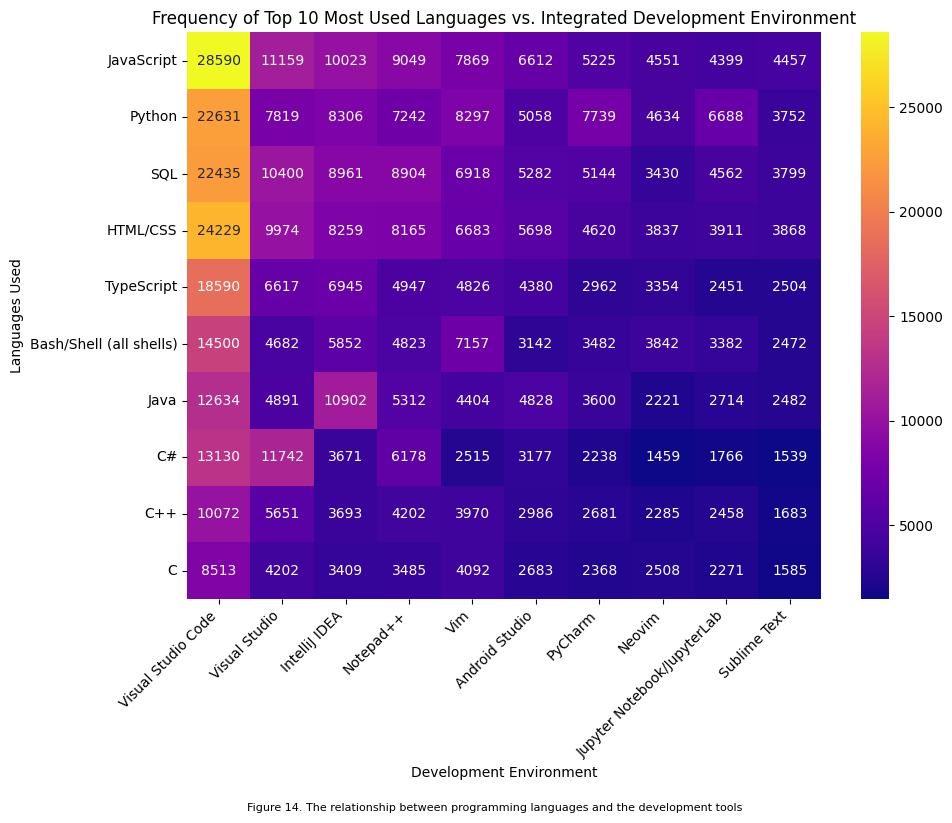

In [44]:
# Selection of relevant columns and drop completely empty rows
df_expl = df_clean[['LanguageHaveWorkedWith', 'NEWCollabToolsHaveWorkedWith']].dropna(how='all').copy()

# Split the cells by ';'
df_expl['LanguageHaveWorkedWith'] = df_expl['LanguageHaveWorkedWith'].str.split(';')
df_expl['NEWCollabToolsHaveWorkedWith'] = df_expl['NEWCollabToolsHaveWorkedWith'].str.split(';')

# Explode both columns so each combination appears as one row 
df_expl = df_expl.explode('LanguageHaveWorkedWith').explode('NEWCollabToolsHaveWorkedWith')

# Setting the top 10 
top_lang = df_expl['LanguageHaveWorkedWith'].value_counts().head(10).index
top_tools = df_expl['NEWCollabToolsHaveWorkedWith'].value_counts().head(10).index

# Filter dataset to keep only Top 10 values for both dimensions
df_top = df_expl[
    df_expl['LanguageHaveWorkedWith'].isin(top_lang) &
    df_expl['NEWCollabToolsHaveWorkedWith'].isin(top_tools)]

# Create a cross-frequency table
contingency_table = (pd.crosstab(df_top['LanguageHaveWorkedWith'], df_top['NEWCollabToolsHaveWorkedWith']).reindex(index=top_lang, columns=top_tools, fill_value=0))

# Plot heatmap of frequencies
plt.figure(figsize=(10, 8))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='plasma')
plt.title("Frequency of Top 10 Most Used Languages vs. Integrated Development Environment")
plt.xlabel("Development Environment")
plt.ylabel("Languages Used")
plt.xticks(rotation=45, ha='right')
plt.tight_layout() # Adjust layout spacing

# Add figure caption below the plot
plt.figtext(0.5, -0.02, 'Figure 14. The relationship between programming languages and the development tools',
            ha='center', fontsize=8)
plt.show() # Show plot

The heatmap reveals clear usage patterns among programming languages and development tools. Languages such as Python, JavaScript, and SQL show broad adoption across multiple platforms, reflecting their versatility.

The most intense cells indicate a strong association between JavaScript and Visual Studio Code, which emerges as the dominant pairing. 

This visualization confirms that while many development environments support multiple languages, developers exhibit specific, strong preferences that define their primary toolkit.

### Finding 3: Compensation & Career

Having profiled who developers are and what technologies they use, I now examine how these factors relate to compensation. This section analyzes salary drivers including experience, role, and technology choices.

#### 3.9 Salary Progression by Professional Experience

I analyzed mean salary across experience levels using the filtered salary dataset, grouping by years of professional coding experience to reveal career compensation trajectories.

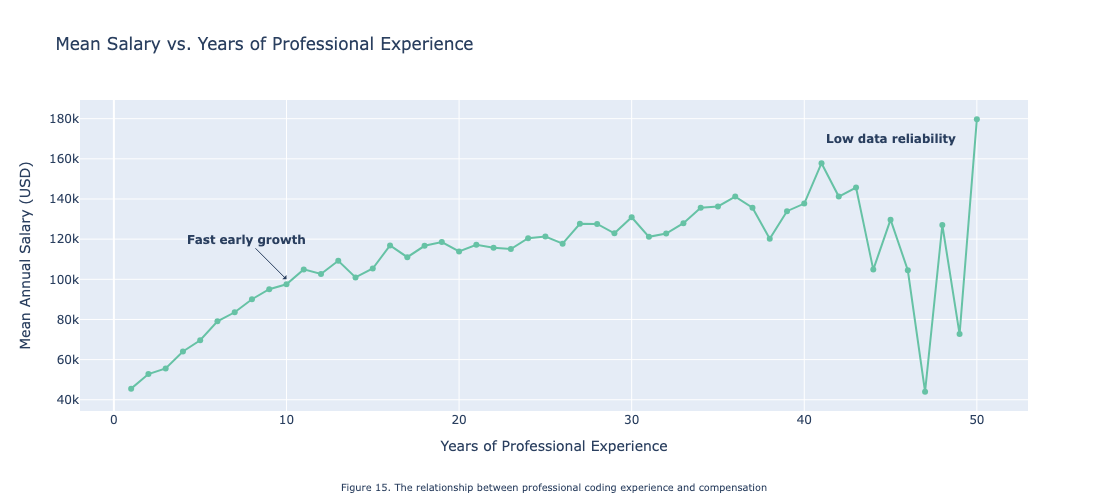

In [45]:
salary_exp_df = df_salary_range.dropna(subset=['YearsCodePro', 'ConvertedCompYearly']) # Drop rows where 'YearsCodePro' or 'ConvertedCompYearly' is missing (NaN)
mean_salary_by_exp = salary_exp_df.groupby('YearsCodePro')['ConvertedCompYearly'].agg(['mean', 'count']).reset_index() # Group by professional experience and calculate the mean salary and user count
mean_salary_by_exp = mean_salary_by_exp.rename(columns={'mean': 'MeanSalary', 'count': 'RespondentCount'}) # Rename the aggregated columns

# Create the Plot
fig = px.line(
    mean_salary_by_exp,
    x='YearsCodePro', y='MeanSalary',
    title='Mean Salary vs. Years of Professional Experience',
    labels={
        'YearsCodePro': 'Years of Professional Experience',
        'MeanSalary': 'Mean Annual Salary (USD)'},
    custom_data=['RespondentCount'],
    markers=True,
    color_discrete_sequence=px.colors.qualitative.Set2)

# Layout adjustments
fig.update_layout(
    width=1100,
    height=500)

# Use fig.update_traces to define the template of the hover
fig.update_traces(
    hovertemplate=(
        "<b>%{x} Years</b><br>" +
        "Mean Salary: %{y:$,.0f}<br>" + 
        "(%{customdata[0]:,.0f} respenses)" +
        "<extra></extra>"))

fig.add_annotation(x=10, y=100000, text="<b>Fast early growth</b>", showarrow=True, arrowhead=1, ax=-40, ay=-40)
fig.add_annotation(x=45, y=170000, text="<b>Low data reliability</b>", showarrow=False)
fig.update_xaxes(title_text='Years of Professional Experience<br><br><sub>Figure 15. The relationship between professional coding experience and compensation</sub>') # Add caption below x-axis title
fig.show() # Show plot

<div class="mathjax_ignore">
The analysis reveals a clear positive relationship between experience and compensation, with important limitations at extreme experience levels.
<br><br>
<b>Early-career growth is dramatic:</b> mean salary increases from approximately $45,000 to over $100,000 during the first 10-12 years. This steep trajectory emphasizes the critical importance of skill development and strategic career moves during the first decade.
<br></br>
<b>Data reliability diminishes after 40 years of experience:</b> extreme volatility appears, with fluctuations like a drop to $44,016 at 47 years based on only 2 responses. These are statistical artifacts from small sample sizes, not meaningful trends.
</div>

#### 3.10 Top 10 Highest-Paying Languages

I analyzed mean salary by programming language after exploding multi-select responses and filtering to languages with at least 200 respondents to ensure statistical reliability.

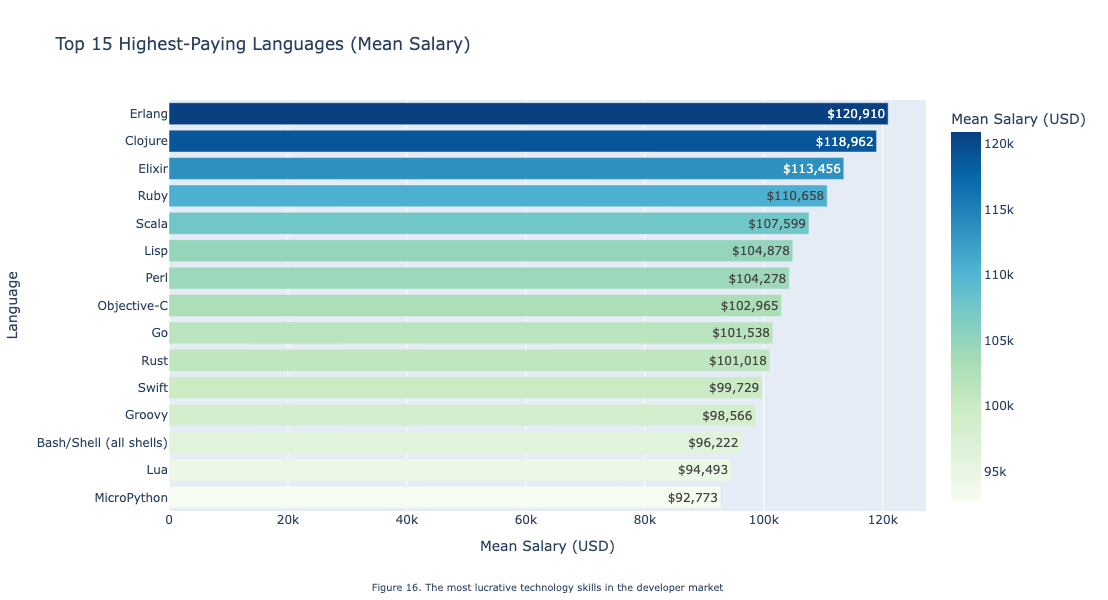

In [46]:
# Splitting the language column
df_lang_salary = df_salary_range[['LanguageHaveWorkedWith', 'ConvertedCompYearly']].dropna()
df_lang_salary = df_lang_salary.assign(Language=df_lang_salary['LanguageHaveWorkedWith'].str.split(';')).explode('Language')

# Calculate mean and count
lang_stats = df_lang_salary.groupby('Language')['ConvertedCompYearly'].agg(['mean', 'count']).reset_index()

# Filter for languages with > 200 respondents
top_paying_lang = lang_stats[lang_stats['count'] > 200].sort_values(by='mean', ascending=False).head(15)

# Create the Plot
fig = px.bar(
    top_paying_lang, 
    x='mean', y='Language',
    title='Top 15 Highest-Paying Languages (Mean Salary)',
    labels={
        'mean': 'Mean Salary (USD)',
        'Language': 'Language'},
    color='mean', color_continuous_scale='GnBu',
    text='mean')

# Layout adjustments
fig.update_layout(
    width=1100,
    height=600,
    yaxis={'categoryorder': 'total ascending'} )

# Use fig.update_traces to define the template of the hover
fig.update_traces(
    texttemplate='$%{text:,.0f}',
    hovertemplate=(
        "<b>%{y}</b><br>" +
        "Mean Salary: %{x:$,.0f}" + 
        "<extra></extra>"))

fig.update_xaxes(title_text='Mean Salary (USD)<br><br><sub>Figure 16. The most lucrative technology skills in the developer market</sub>') # Add caption below x-axis title
fig.show() # Show plot

<div class="mathjax_ignore">
<b>The top paying languages reveal a clear pattern:</b> functional programming and specialized systems languages dominate. The three highest earners are Erlang ($120,910), Clojure ($118,962), and Elixir ($113,456) all functional languages used in specialized, high scale distributed systems. 
<br><br>
<b>Specialization trumps popularity:</b> notably absent from the top earners are the most widely used languages like JavaScript and Python. This demonstrates that high compensation correlates with specialized expertise and niche demand rather than broad adoption.
<br><br>
The pattern suggests that developers seeking higher compensation should consider strategic specialization in languages that solve business critical problems in high value industries, rather than focusing solely on popularity metrics.
</div>

#### 3.11 Top 10 Highest-Paying Developer Roles

I analyzed mean salary by developer role, filtering to positions with sufficient sample sizes to ensure reliable comparisons.

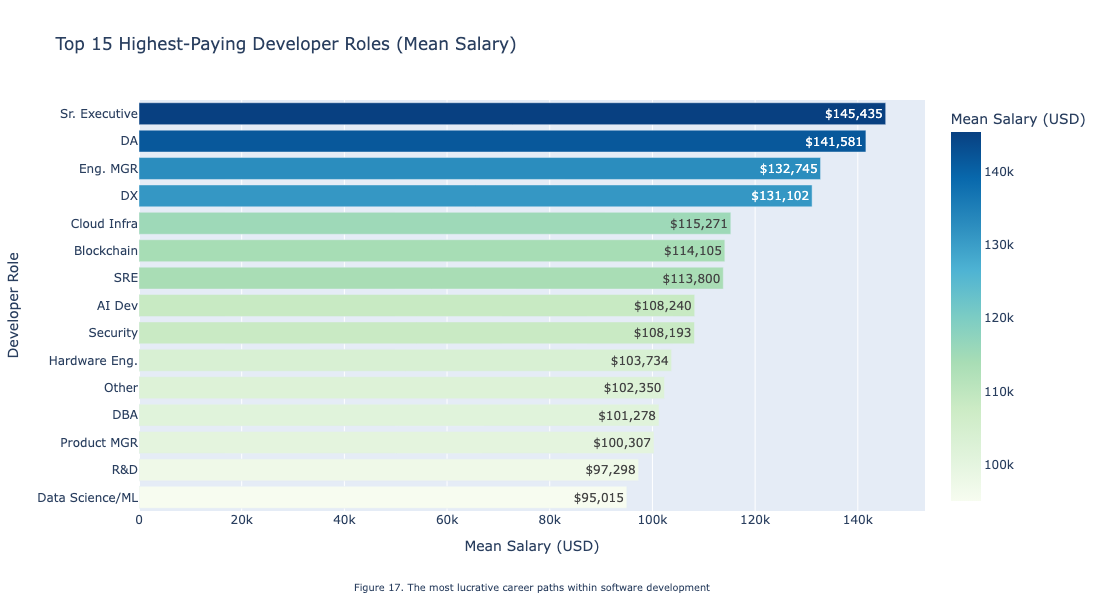

In [47]:
salary_role = df_salary_range.groupby('DevType_clean')['ConvertedCompYearly'].mean().sort_values(ascending=False).head(15).reset_index()

# Create the Plot
fig = px.bar(
    salary_role,
    x='ConvertedCompYearly', y='DevType_clean',
    title='Top 15 Highest-Paying Developer Roles (Mean Salary)',
    labels={
        'ConvertedCompYearly': 'Mean Salary (USD)',
        'DevType_clean': 'Developer Role'},
    color='ConvertedCompYearly', color_continuous_scale='GnBu',
    text='ConvertedCompYearly')

# Layout adjustments
fig.update_layout(
    width=1100,
    height=600,
    yaxis={'categoryorder': 'total ascending'} )

# Use fig.update_traces to define the template of the hover
fig.update_traces(
    texttemplate='$%{text:,.0f}',
    hovertemplate=(
        "<b>%{y}</b><br>" +
        "Mean Salary: %{x:$,.0f}" + 
        "<extra></extra>"))

fig.update_xaxes(title_text='Mean Salary (USD)<br><br><sub>Figure 17. The most lucrative career paths within software development</sub>') # Add caption below x-axis title
fig.show() # Show plot

<div class="mathjax_ignore">
<b>The compensation hierarchy reveals a clear pattern:</b> leadership and specialized technical roles command premium salaries. Senior Executive positions top the list at approximately $145,000, followed closely by Developer Advocate ($138,000) and Engineering Manager ($135,000). This confirms that management responsibility and strategic technical influence directly correlate with higher compensation.
<br><br>

<b>Notably, Data Science/ML roles ($95,015) rank at the bottom of the top 15,</b> despite widespread perception of data science as a high paying field. While still well compensated, data scientists earn less on average than 14 other developer specializations.
</div>

#### 3.12 Salary vs. Experience by Programming Language

I created a scatter plot analyzing the relationship between mean salary, mean professional experience, and respondent count for each programming language, filtering to languages with at least 100 respondents for reliability.

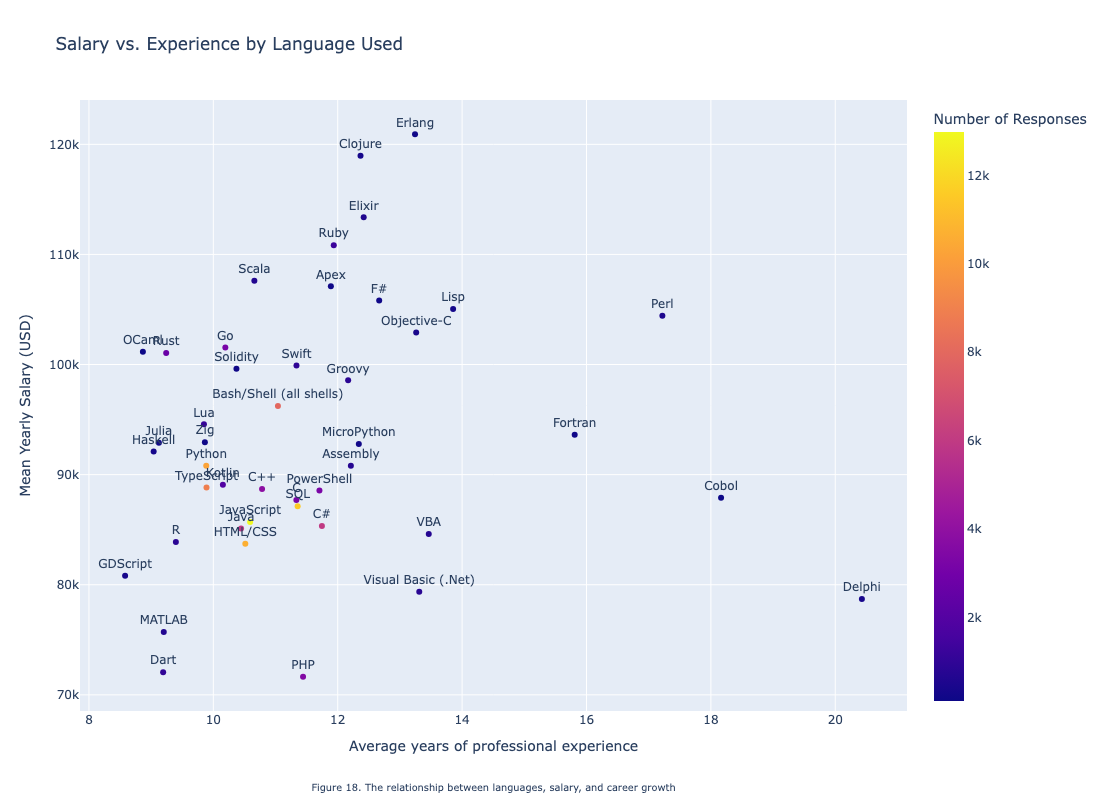

In [48]:
# Select the 3 columns we need and drop empty rows
df_scatter = df_salary_range[['LanguageHaveWorkedWith', 'ConvertedCompYearly', 'YearsCodePro']].dropna()

# 'Explode' the languages
df_scatter = df_scatter.assign(Language=df_scatter['LanguageHaveWorkedWith'].str.split(';')).explode('Language')

# Group by language and calculate the 3 metrics we want to plot
df_scatter = df_scatter.groupby('Language').agg(
    Mean_Salary=('ConvertedCompYearly', 'mean'),    # Y axis
    Average_Experience=('YearsCodePro', 'mean'),    # X axis 
    Respondent_Count=('Language', 'count'))         # Color

# Filter out languages with fewer than 100 responses
df_scatter = df_scatter[df_scatter['Respondent_Count'] > 100].reset_index()

# Create the Plot
fig = px.scatter(
    df_scatter,
    x='Average_Experience', y='Mean_Salary',
    color='Respondent_Count', text='Language',
    custom_data=['Language', 'Respondent_Count'],
    title='Salary vs. Experience by Language Used',
    labels={
        'Average_Experience': 'Average years of professional experience',
        'Mean_Salary': 'Mean Yearly Salary (USD)',
        'Respondent_Count': 'Number of Responses'},
    color_continuous_scale=px.colors.sequential.Plasma)

# Use fig.update_traces to define the template of the hover
fig.update_traces(
    textposition='top center',
    hovertemplate=(
        "<b>%{customdata[0]}</b><br><br>" +
        "%{y:$,.0f}<br>" +
        "%{x:.0f} years<br>" +
        "(%{customdata[1]:,.0f} responses)"))

# Layout adjustments
fig.update_layout(
    height=800,
    width=1100)

fig.update_xaxes(title_text='Average years of professional experience<br><br><sub>Figure 18. The relationship between languages, salary, and career growth</sub>') # Add caption below x-axis title
fig.show() # Show plot

<div class="mathjax_ignore">
The visualization reveals a clear inverse relationship between language popularity and compensation:
<br><br>
<b>High-salary specialists:</b> Erlang, Clojure and Perl(12-14+ years, $110k-$121k) cluster in the upper right, demonstrating that mature, niche technologies reward sustained specialization where experienced practitioners are scarce.
<br><br>
<b>Popular mainstream languages:</b> JavaScript ($85K, 11 years), Python ($90K, 10 years), and SQL ($87K, 11 years) occupy the lower middle range.
<br><br>
    
Emerging systems languages like Rust ($101K, 9 years) and Go ($101K, 10 years) occupy middle ground, offering strong salaries without requiring 14+ years of specialization.
</div>

#### 3.13 Salary vs. Experience by Developer Role

In this final section, I analyzed mean salary, mean professional experience, and respondent count for each developer role using a scatter plot to identify career paths offering the best compensation to experience ratios.

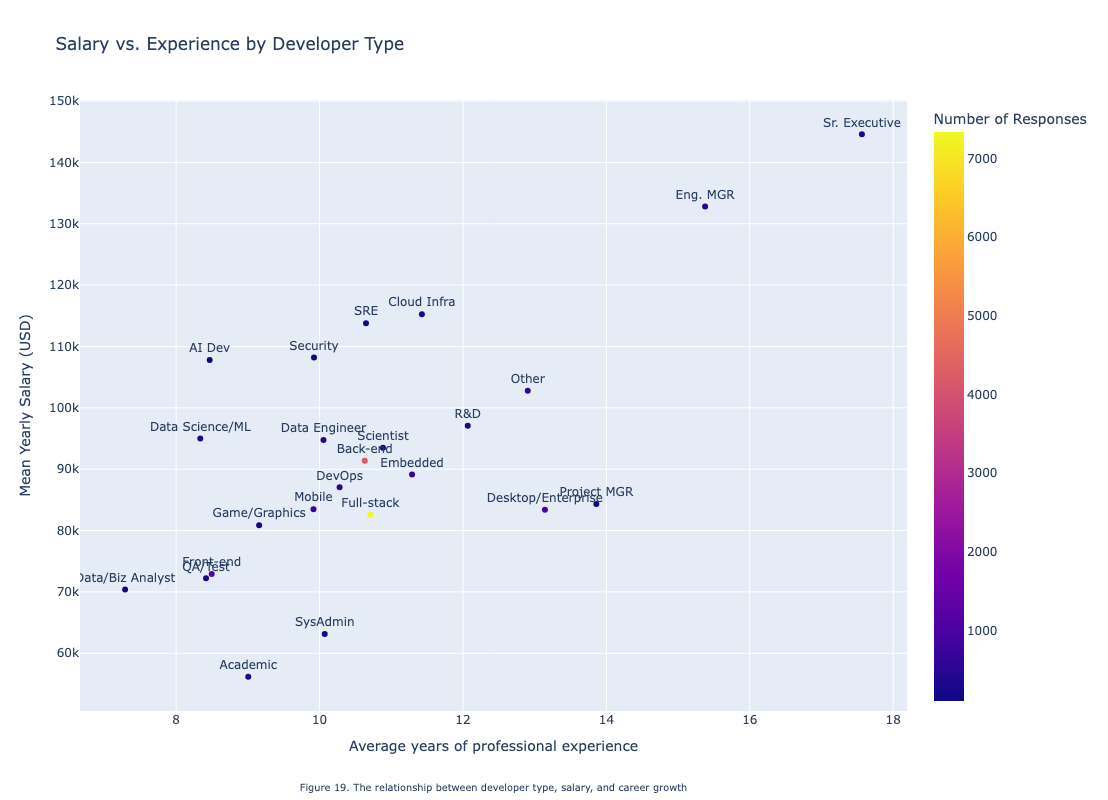

In [49]:
# Select the 3 columns we need and drop empty rows
df_scatter = df_salary_range[['DevType_clean', 'ConvertedCompYearly', 'YearsCodePro']].dropna()

# Group by language and calculate the 3 metrics we want to plot
df_scatter = df_scatter.groupby('DevType_clean').agg(
    Mean_Salary=('ConvertedCompYearly', 'mean'),     # Y axis
    Average_Experience=('YearsCodePro', 'mean'),     # X axis 
    Respondent_Count=('DevType_clean', 'count'))     # Color

# Filter out languages with fewer than 100 responses
df_scatter = df_scatter[df_scatter['Respondent_Count'] > 100].reset_index()

# Create the Plot
fig = px.scatter(
    df_scatter,
    x='Average_Experience', y='Mean_Salary',
    color='Respondent_Count', text='DevType_clean',
    custom_data=['DevType_clean', 'Respondent_Count'],
    title='Salary vs. Experience by Developer Type',
    labels={
        'Average_Experience': 'Average years of professional experience',
        'Mean_Salary': 'Mean Yearly Salary (USD)',
        'Respondent_Count': 'Number of Responses'},
    color_continuous_scale=px.colors.sequential.Plasma)

# Use fig.update_traces to define the template of the hover
fig.update_traces(
    textposition='top center',
    hovertemplate=(
        "<b>%{customdata[0]}</b><br><br>" +
        "%{y:$,.0f}<br>" +
        "%{x:.0f} years<br>" +
        "(%{customdata[1]:,.0f} responses)"))

# Layout adjustments
fig.update_layout(
    height=800,
    width=1100)

fig.update_xaxes(title_text='Average years of professional experience<br><br><sub>Figure 19. The relationship between developer type, salary, and career growth</sub>') # Add caption below x-axis title
fig.show() # Show plot

<div class="mathjax_ignore">
<b>Leadership dominates:</b> Senior Executive ($144K, 18 years) and Engineering Manager ($132K, 15 years) occupy the highest compensation tier, confirming that management responsibility delivers premium pay.
<br><br> 
<b>Popular roles show modest returns:</b> Full-stack ($82K, 11 years) represents the largest group but earns moderate compensation despite experience, reflecting market saturation from high supply.
<br><br>
    
<b>Clear progression pathway:</b> roles flow from entry positions like Data Analyst through DevOps Engineer and Security Professional to Engineering Manager, showing strong positive correlation between experience and salary.
</div>

## 4. Conclusion & Next Steps

This analysis of the 2024 Stack Overflow Developer Survey reveals critical insights into developer demographics, technology trends, and compensation drivers.

* **Key Findings:**

<div class="mathjax_ignore">
<b>The Developer Profile:</b> The typical 2024 developer is 33 years old, holds a Bachelor's degree, and works in a Hybrid role, followed by Remote work. Geographic concentration remains strong in the USA, Germany, and India, representing over one third of responses.
<br></br>
<b>The Developer's Toolkit:</b> JavaScript, SQL, Python, and HTML/CSS remain foundational technologies with highest current usage. However, developer interest has shifted toward Rust, Go, signaling industry movement toward systems languages, performance optimization, and data driven applications.
<br></br>
<b>Compensation Dynamics:</b> The salary analysis reveals three critical findings:<br>
    1. Specialization over popularity: The highest paying languages (Erlang, Clojure) and roles (Senior Executive, Security) are not the most common, demonstrating that niche expertise commands premium compensation.<br>
    2. Early career acceleration: Salary growth is most dramatic in the first 10-12 years, increasing from ~$45K to over $100K.<br>
    3. Depth over range: Technology Range Metrics (2.5.2) showed zero correlation between number of technologies known and salary, proving that deep expertise in high value specializations drives compensation, not range.
</div>

* **Limitations:**

<div class="mathjax_ignore">
<b>Salary Data Scarcity:</b> Analysis used 20,903 validated salary responses (35.5% of dataset) between $10K-$500K, ensuring reliability but potentially limiting generalizability to the full developer population.
</div>

* **Future Research Directions:**

**Predictive modeling:** Build a machine learning model using experience, role, education, and skill features to predict salary, enabling developers to estimate compensation for different career paths.

**Remote work compensation analysis:** Conduct statistical testing to determine whether Remote, Hybrid, or In-person arrangements correlate with salary differences after controlling for experience, role, and location.